In [1]:
import datetime as dt
from os import getcwd
from os.path import dirname, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la

from MAMMAL.Utils import ProcessingUtils as pu
from MAMMAL.Utils import Filters as filt
from MAMMAL.VehicleCal import magUtilsTL as magtl


%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 30) # (w, h)
plt.style.use(['seaborn-poster', 'seaborn-white'])
pd.set_option('mode.chained_assignment', None)



LOG_CSV_FNAME = join(getcwd(), 'data', '__ground_cal__.csv')
CAL_NAME      = 'MFAM Ground Tolles Lawson'

START_DT = dt.datetime(2022, 11, 8, 20, 16, 30)
END_DT   = dt.datetime(2022, 11, 8, 20, 21, 0)


def precal_plots(timestamps, b_scalar, mfam_vec_dcs, vmr_dcs):
    _, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(7, 1, sharex=True)

    ax0.plot(timestamps, b_scalar)
    ax0.set_title('Sensor Measurements (Inside UAV)')
    ax0.set_ylabel('nT')
    ax0.set_xlabel('Timestamp')
    ax0.grid()

    ax1.plot(timestamps, mfam_vec_dcs[:, 0])
    ax1.set_title('MFAM Direction Cosines X-Component (Inside UAV)')
    ax1.set_xlabel('Timestamp')
    ax1.grid()

    ax2.plot(timestamps, mfam_vec_dcs[:, 1])
    ax2.set_title('MFAM Direction Cosines Y-Component (Inside UAV)')
    ax2.set_xlabel('Timestamp')
    ax2.grid()

    ax3.plot(timestamps, mfam_vec_dcs[:, 2])
    ax3.set_title('MFAM Direction Cosines Z-Component (Inside UAV)')
    ax3.set_xlabel('Timestamp')
    ax3.grid()

    ax4.plot(timestamps, vmr_dcs[:, 0])
    ax4.set_title('VMR Direction Cosines X-Component (Inside UAV)')
    ax4.set_xlabel('Timestamp')
    ax4.grid()

    ax5.plot(timestamps, vmr_dcs[:, 1])
    ax5.set_title('VMR Direction Cosines Y-Component (Inside UAV)')
    ax5.set_xlabel('Timestamp')
    ax5.grid()

    ax6.plot(timestamps, vmr_dcs[:, 2])
    ax6.set_title('VMR Direction Cosines Z-Component (Inside UAV)')
    ax6.set_xlabel('Timestamp')
    ax6.grid()

def postcal_plots(scalar_ts, b_scalar, b_scalar_truth, cal_scalar, dcs):
    _, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex=True)

    ax0.plot(scalar_ts, b_scalar)
    ax0.plot(scalar_ts, b_scalar_truth, label='Truth')
    ax0.set_title('Uncalibrated Scalar Measurements with Truth (Inside UAV)')
    ax0.set_ylabel('nT')
    ax0.set_xlabel('Timestamp')
    ax0.legend()
    ax0.grid()

    ax1.plot(scalar_ts, cal_scalar)
    ax1.plot(scalar_ts, b_scalar_truth, label='Truth')
    ax1.set_title('Calibrated Scalar Measurements with Truth (Inside UAV)')
    ax1.set_ylabel('nT')
    ax1.set_xlabel('Timestamp')
    ax1.legend()
    ax1.grid()

    ax2.plot(scalar_ts, dcs[:, 0])
    ax2.set_title('Direction Cosines X-Component Measurements (Inside UAV)')
    ax2.set_xlabel('Timestamp')
    ax2.grid()

    ax3.plot(scalar_ts, dcs[:, 1])
    ax3.set_title('Direction Cosines Y-Component Measurements (Inside UAV)')
    ax3.set_xlabel('Timestamp')
    ax3.grid()

    ax4.plot(scalar_ts, dcs[:, 2])
    ax4.set_title('Direction Cosines Z-Component Measurements (Inside UAV)')
    ax4.set_xlabel('Timestamp')
    ax4.grid()

# Load Calibration Data

In [2]:
log_df = pd.read_csv(LOG_CSV_FNAME, parse_dates=['datetime'])
log_df = log_df[(log_df.datetime > START_DT) & (log_df.datetime < END_DT)]

datetimes  = log_df.datetime
timestamps = np.array(log_df.epoch_sec)

# Compare Each Head Vs Averaged Values

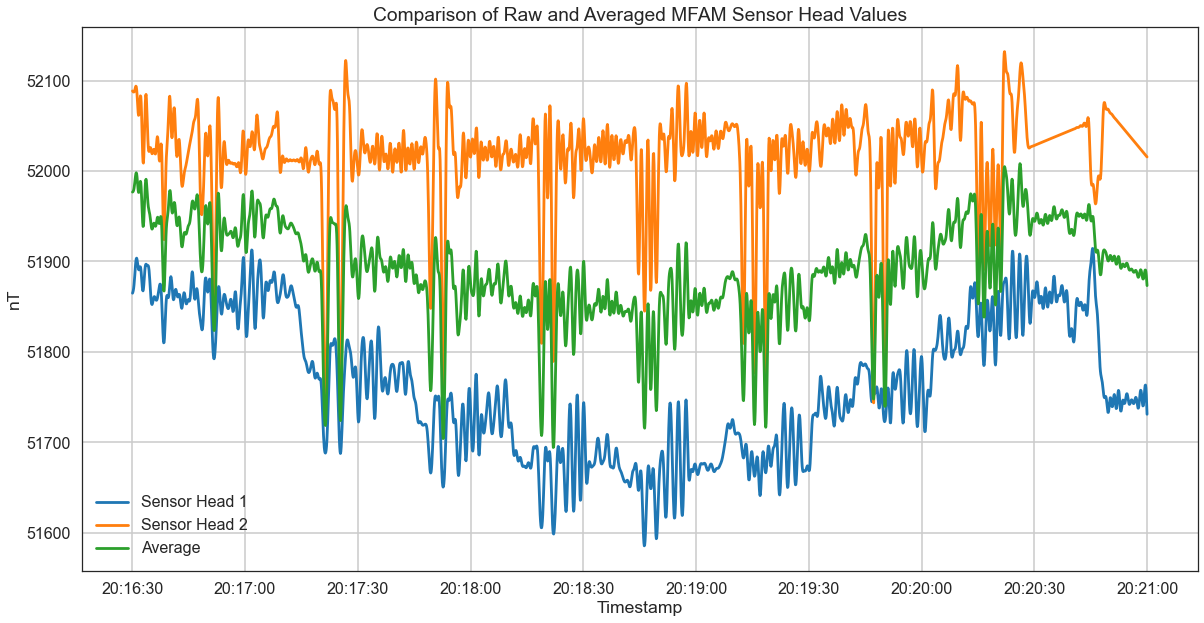

In [3]:
plt.rcParams["figure.figsize"] = (20, 10) # (w, h)

plt.figure()
plt.title('Comparison of Raw and Averaged MFAM Sensor Head Values')
plt.plot(log_df.datetime, filt.lpf(log_df.SCALAR_1_LPF, 1, 10, 10), label='Sensor Head 1')
plt.plot(log_df.datetime, filt.lpf(log_df.SCALAR_2_LPF, 1, 10, 10), label='Sensor Head 2')
plt.plot(log_df.datetime, (filt.lpf(log_df.SCALAR_1_LPF, 1, 10, 10) + filt.lpf(log_df.SCALAR_2_LPF, 1, 10, 10)) / 2.0, label='Average')
plt.xlabel('Timestamp')
plt.ylabel('nT')
plt.grid()
plt.legend()
plt.show()

plt.rcParams["figure.figsize"] = (30, 30) # (w, h)

# Calibrate MFAM Sensor in UAV

# Prune/Preprocess Data

In [4]:
b_scalar = (log_df.SCALAR_1_LPF + log_df.SCALAR_2_LPF) / 2.0

vmr = np.hstack([np.array(log_df.X)[:, np.newaxis], 
                 np.array(log_df.Y)[:, np.newaxis],
                 np.array(log_df.Z)[:, np.newaxis]])
vmr_magnitude = la.norm(vmr, axis=1)
vmr_dcs = vmr / vmr_magnitude[:, np.newaxis]

mfam_vec = np.hstack([np.array(log_df.X_MFAM)[:, np.newaxis], 
                      np.array(log_df.Y_MFAM)[:, np.newaxis],
                      np.array(log_df.Z_MFAM)[:, np.newaxis]])
mfam_vec_magnitude = la.norm(mfam_vec, axis=1)
mfam_vec_dcs = mfam_vec / mfam_vec_magnitude[:, np.newaxis]

# Pre-Calibration Plots

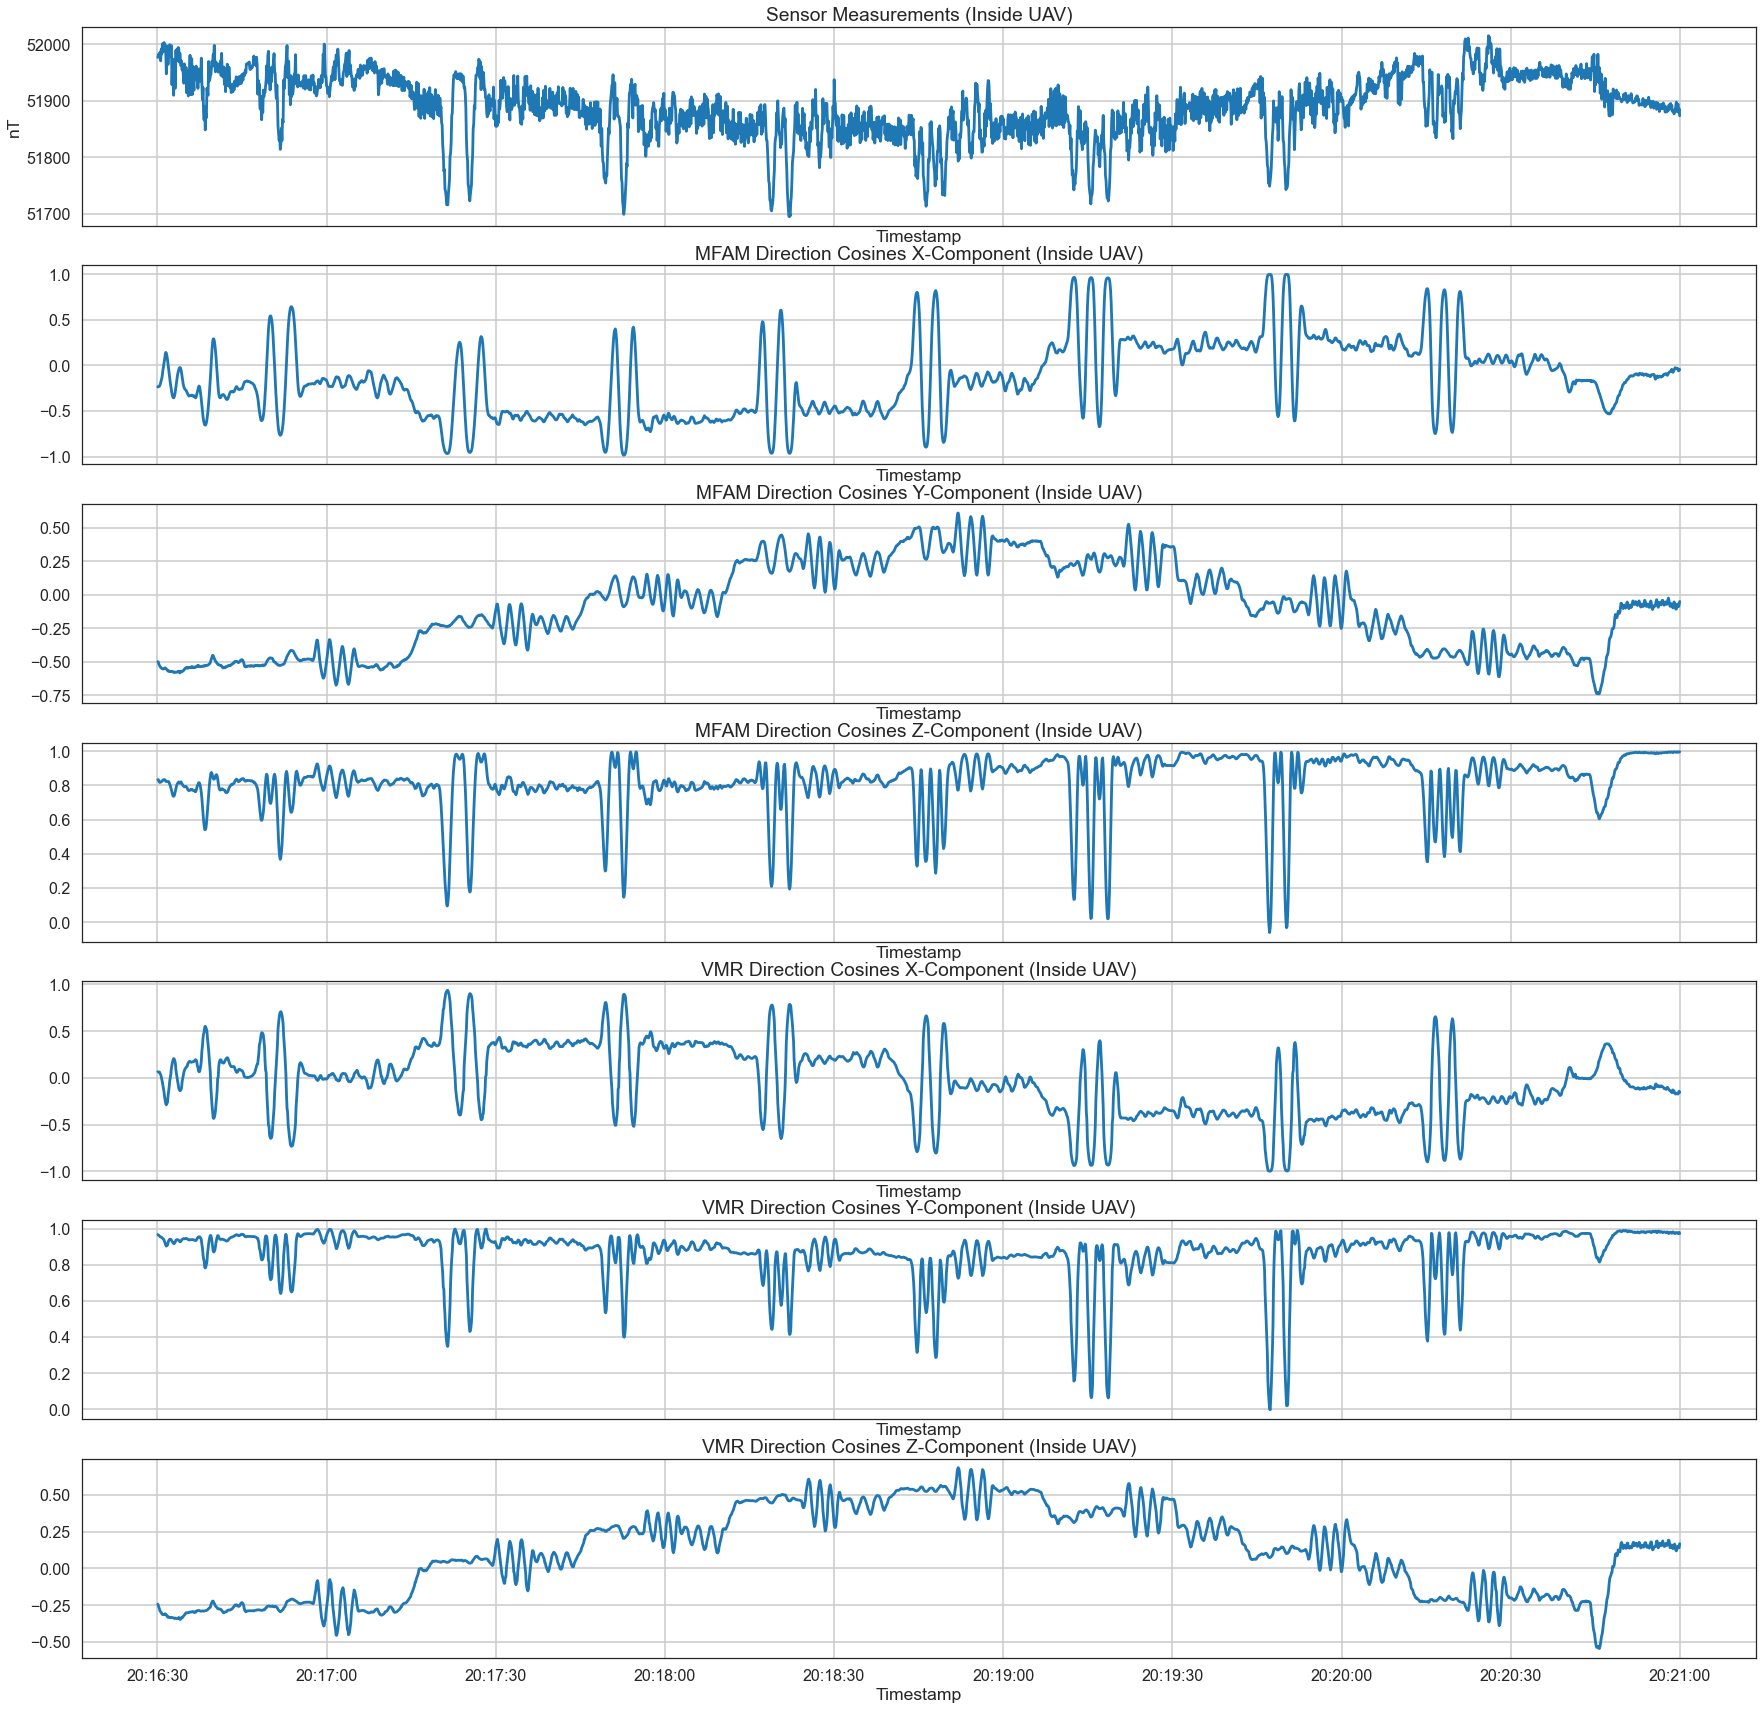

In [5]:
precal_plots(datetimes,
             b_scalar,
             mfam_vec_dcs,
             vmr_dcs)

# Find/Apply Tolles Lawson (TL) Calibration Coefficients (All TL Terms + MFAM Vector Sensor)

In [6]:
tl_terms = magtl.DEFAULT_TL_TERMS

b_vector = mfam_vec

scalar_ts = timestamps
delta_t     = np.diff(scalar_ts).mean()

filt = magtl.Filter(order = 10,
                    fcut  = [0.1, 2.0],
                    btype = 'band',
                    ftype = 'butter',
                    fs    = (1.0 / delta_t))

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 5.70657355e+01 -1.12763248e+02  2.21579936e+02 -1.29875018e+04
 -4.99187899e+02 -7.12973512e+04  1.13955716e+05 -9.57637214e+04
 -4.50833457e+04  1.83142845e+04 -8.99594518e+03  2.92805550e+03
  3.61167791e+03  5.45811696e+04 -3.29564152e+03  4.12762648e+03
 -8.64986919e+03  2.67089442e+04]
RMSE: 22.52599143021509


# Post-Calibration Plots (All TL Terms + MFAM Vector Sensor)

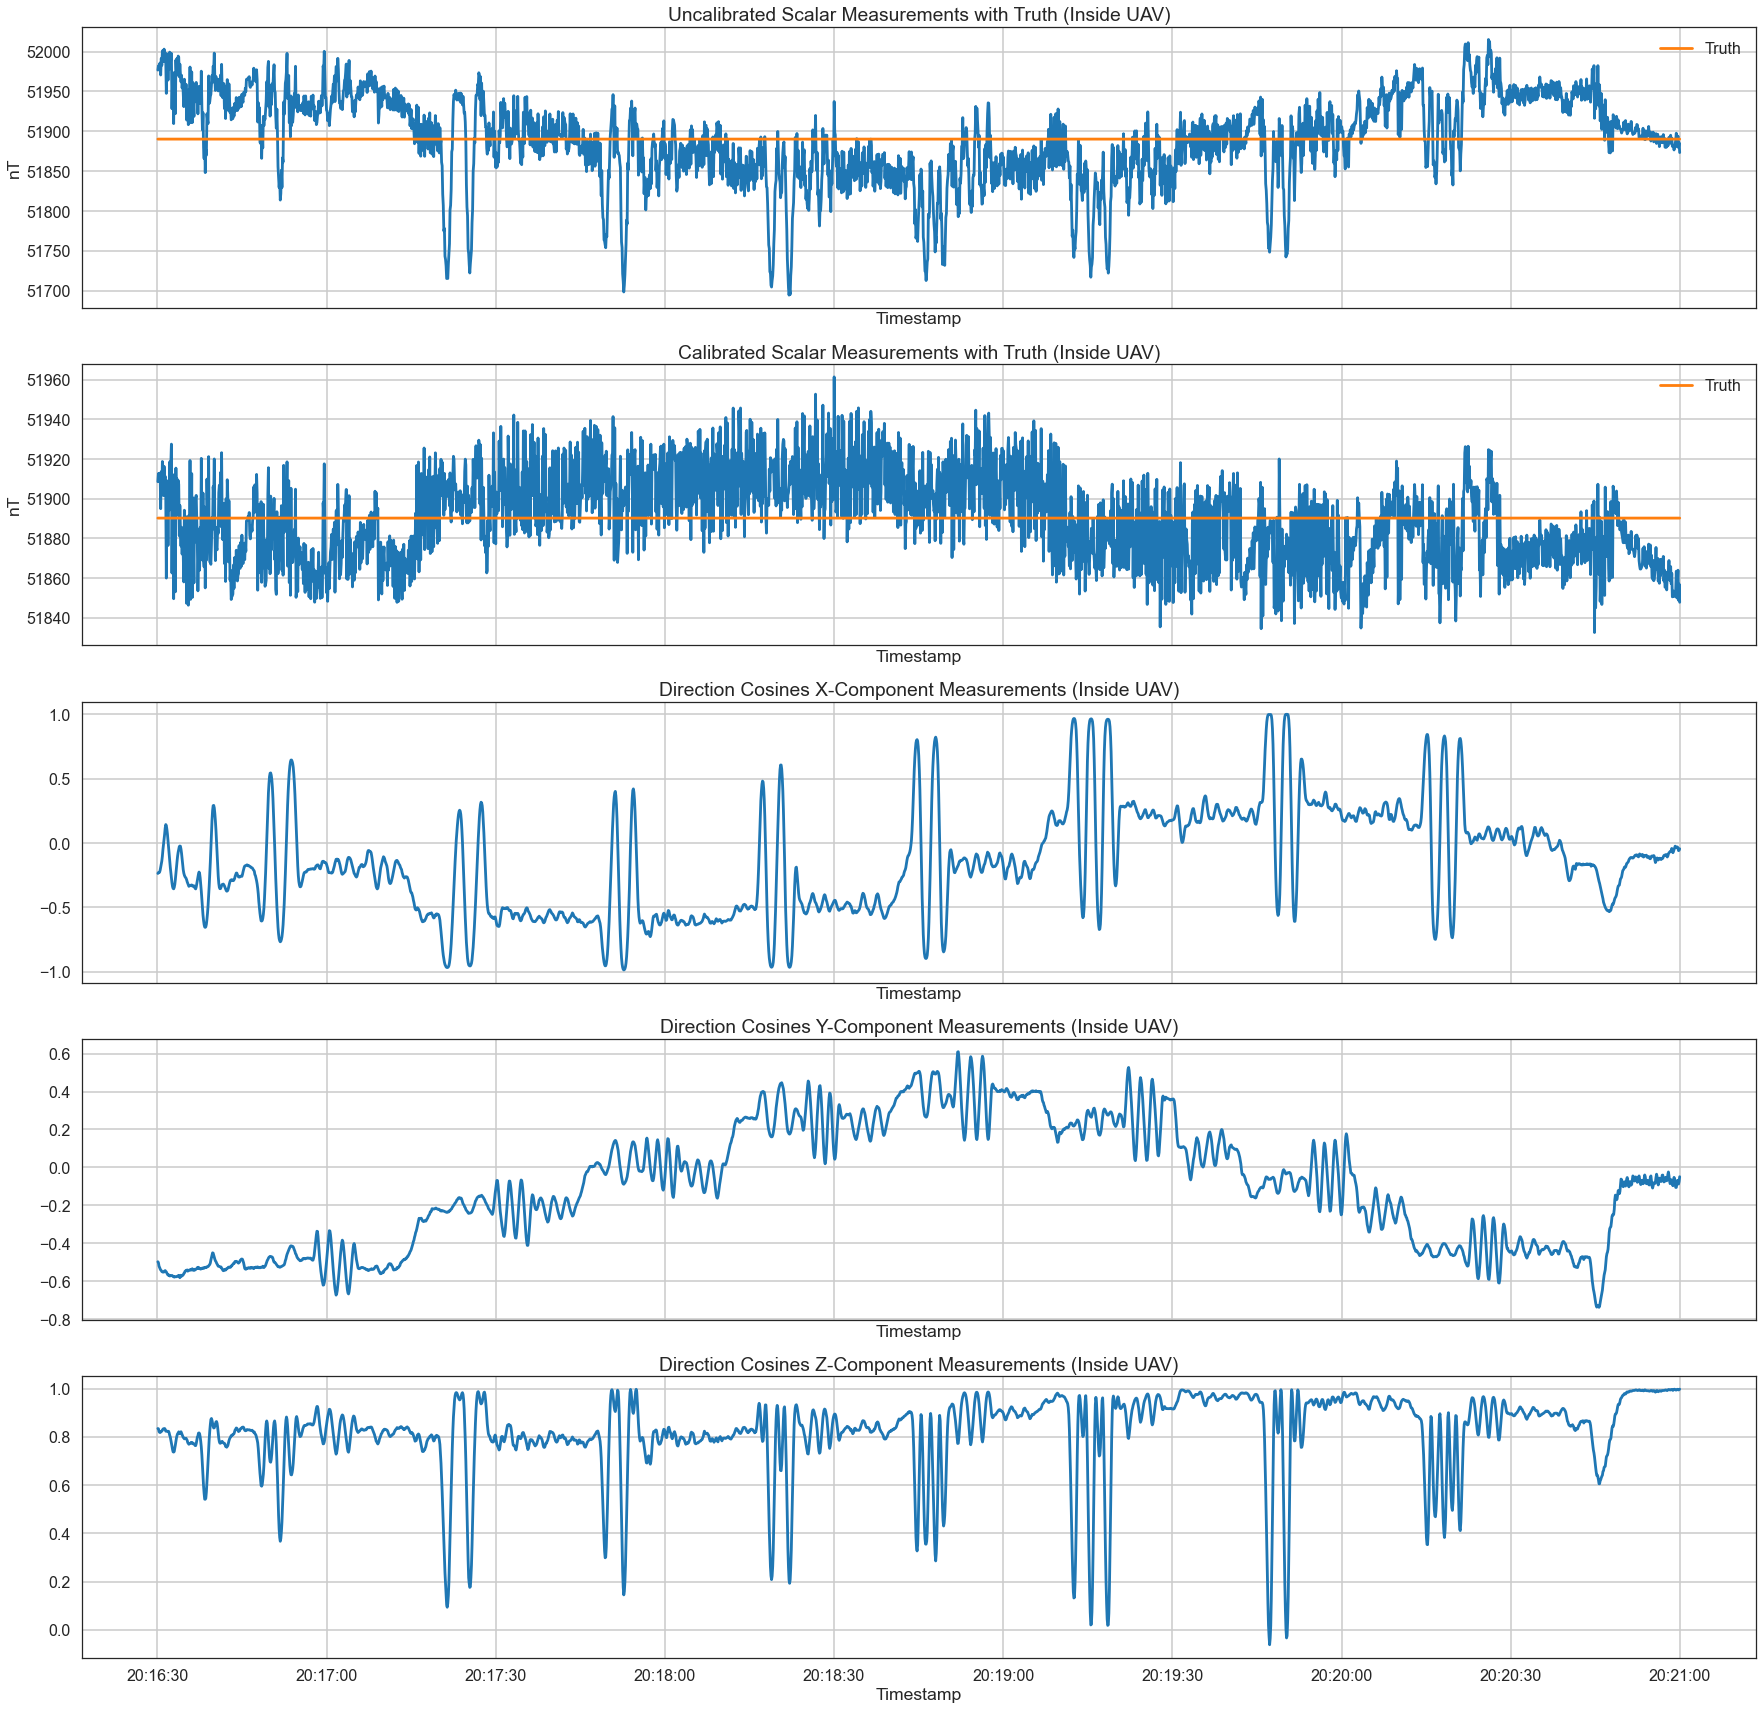

In [7]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply TL Calibration Coefficients (Permanent and Induced TL Terms + MFAM Vector Sensor)

In [8]:
tl_terms = [magtl.TollesLawsonTerms.PERMANENT,
            magtl.TollesLawsonTerms.INDUCED]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 5.26214900e+01 -1.21125228e+02  2.15786105e+02 -9.95712052e+04
  1.61563819e+03 -6.94848124e+04  2.98398549e+04 -9.33704452e+04
 -1.31525435e+05]
RMSE: 22.539035708860144


# Post-Calibration Plots (Permanent and Induced TL Terms + MFAM Vector Sensor)

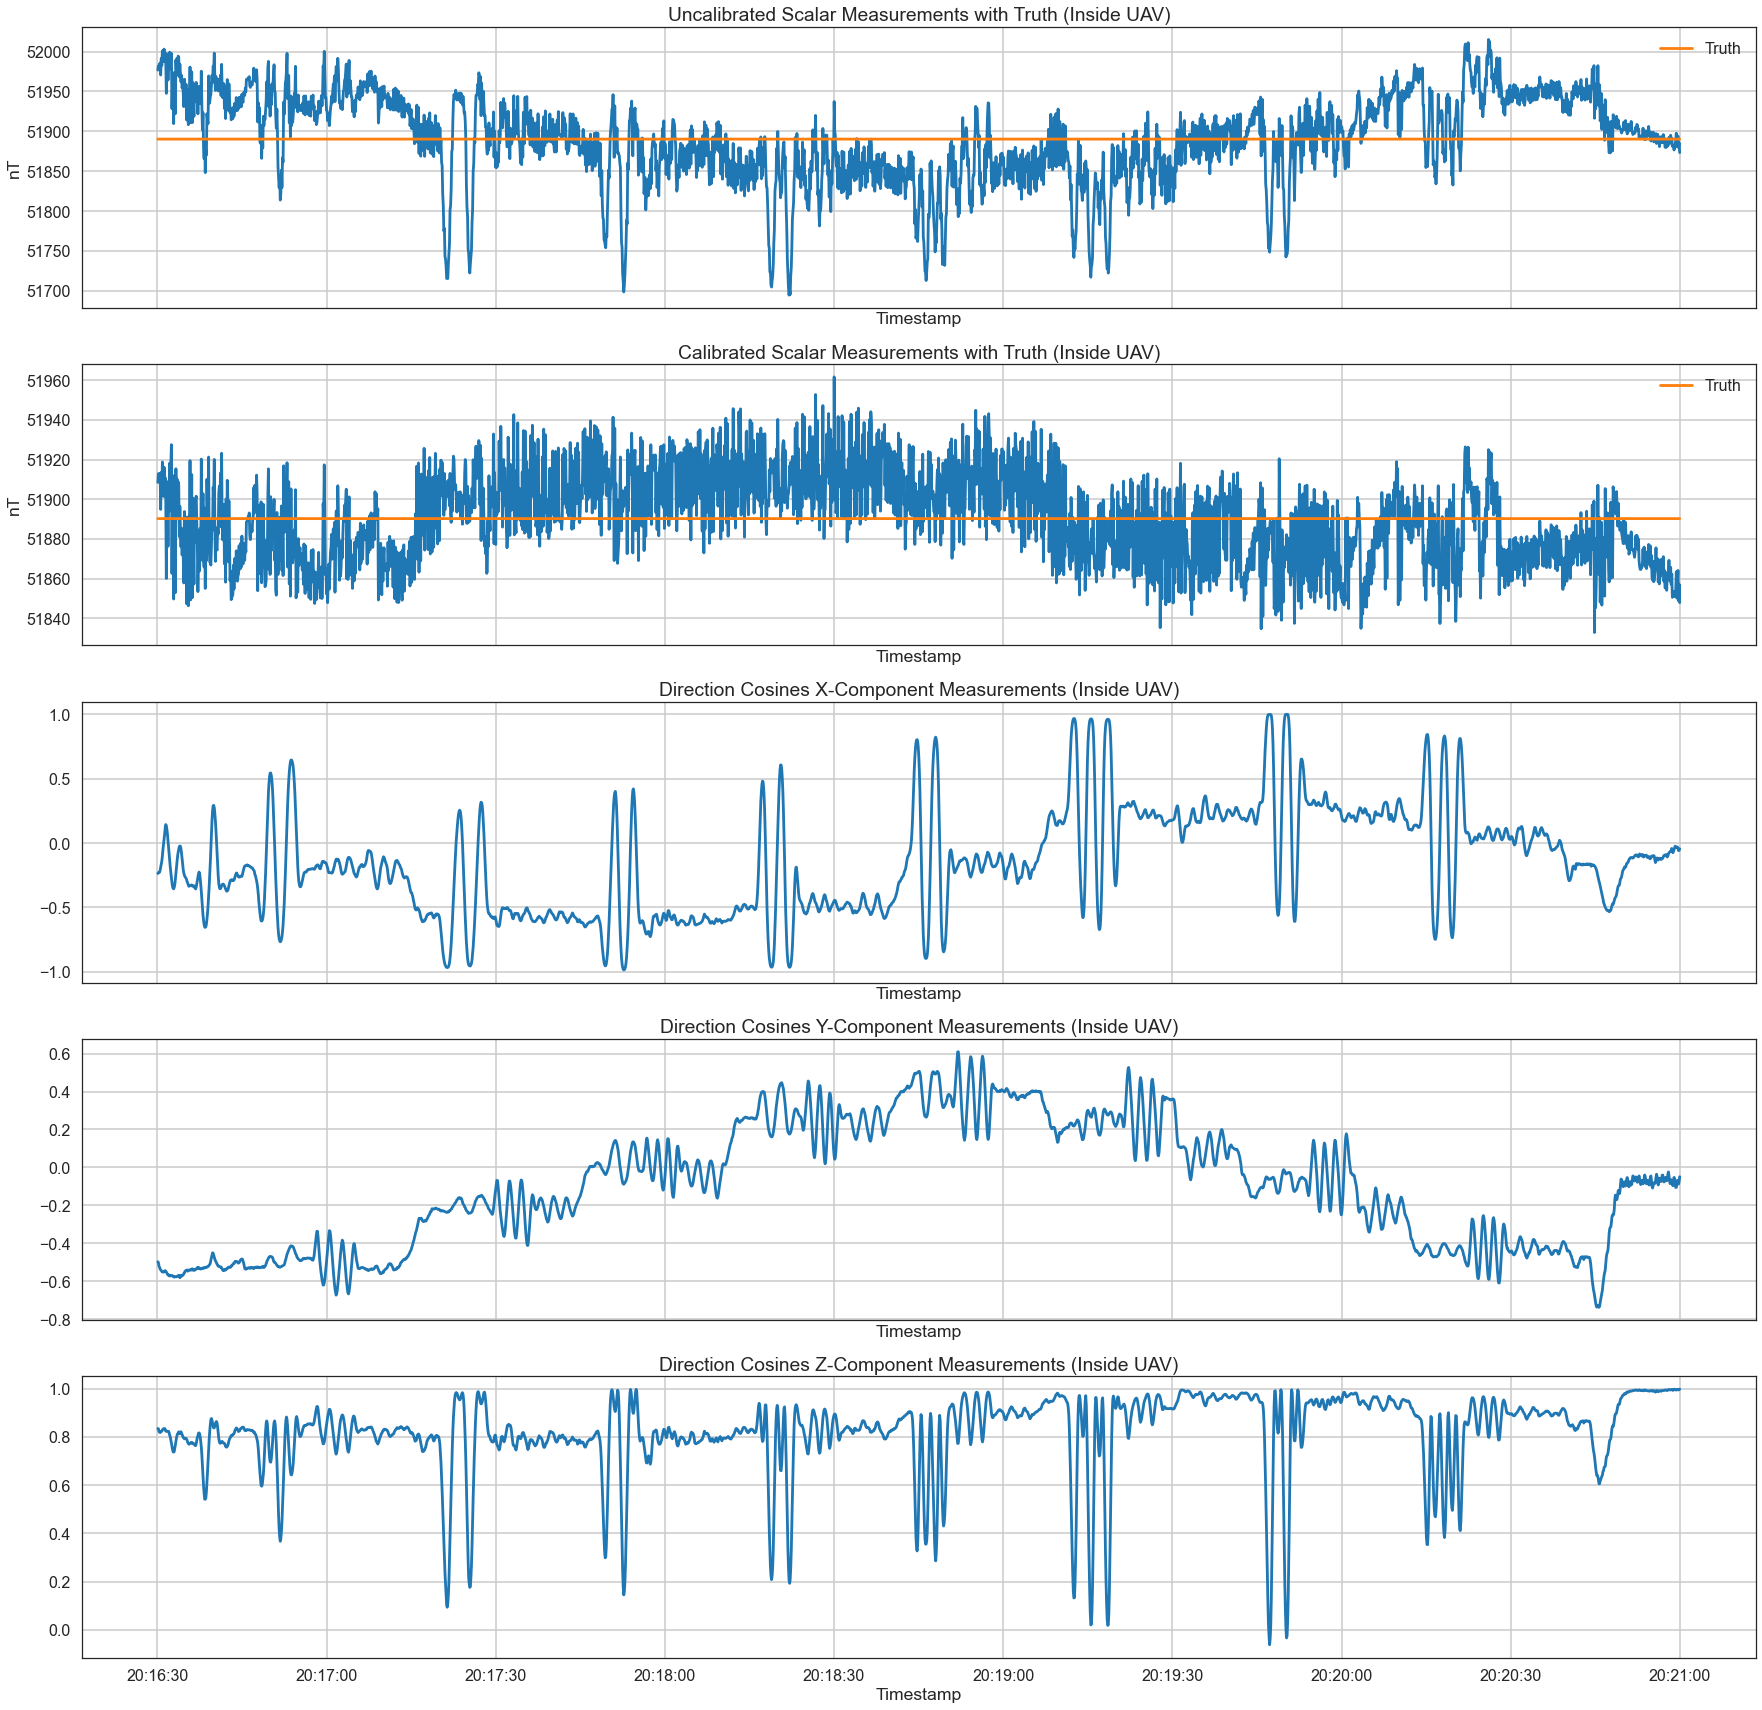

In [9]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply TL Calibration Coefficients (Permanent TL Terms + MFAM Vector Sensor)

In [10]:
tl_terms = [magtl.TollesLawsonTerms.PERMANENT]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [  43.26481885 -143.49388132  200.73471691]
RMSE: 23.436190685700087


# Post-Calibration Plots (Permanent TL Terms + MFAM Vector Sensor)

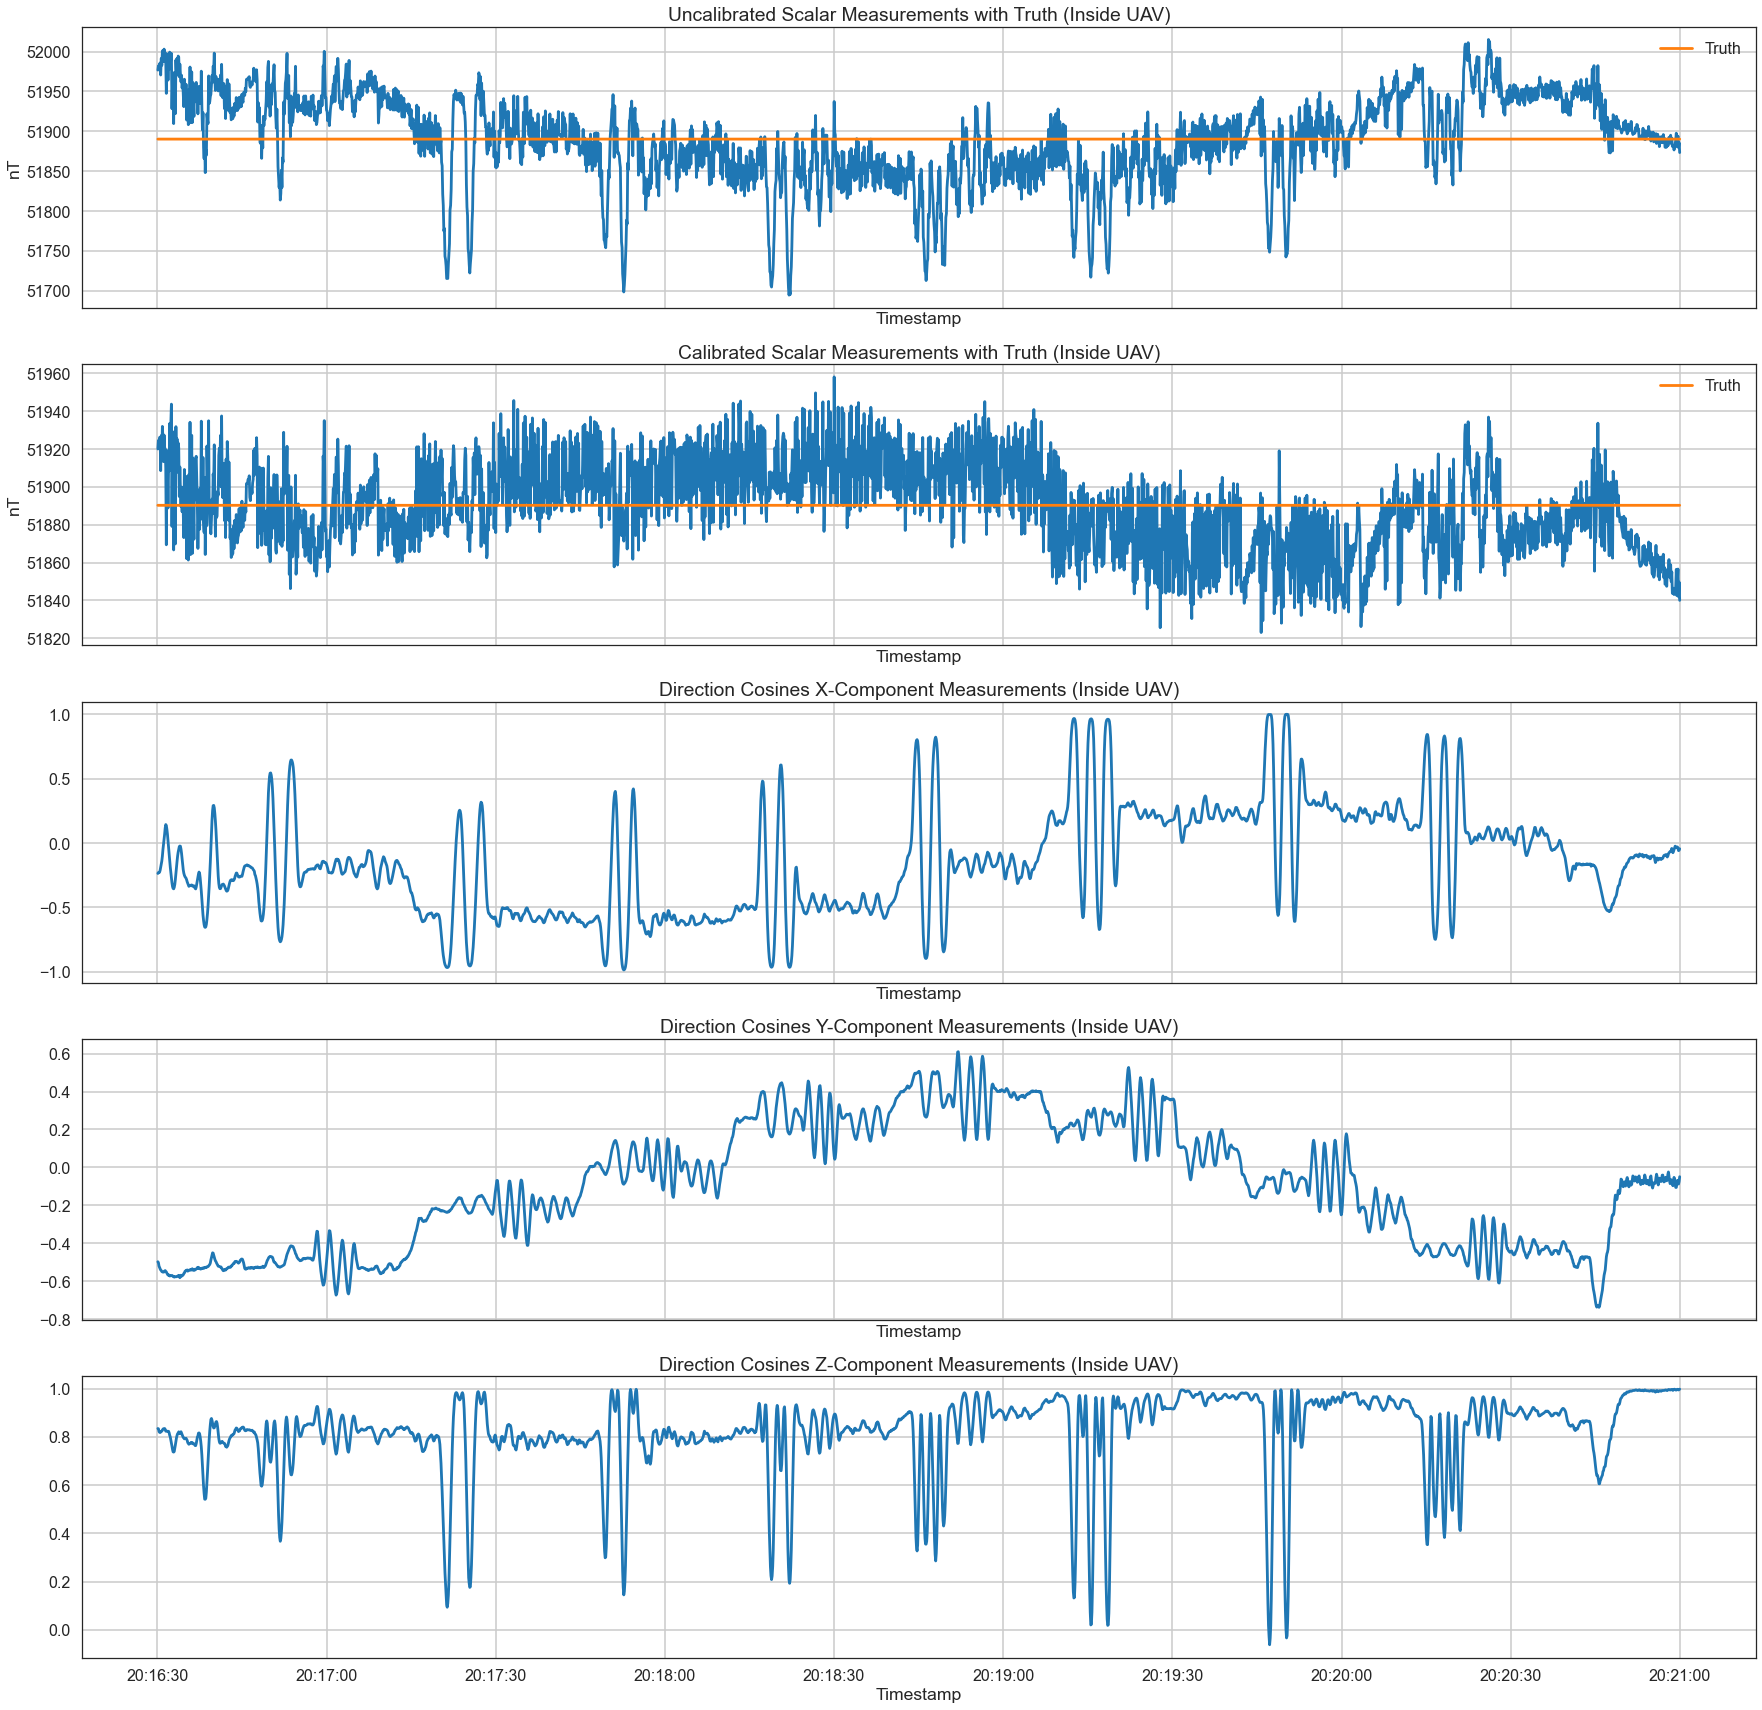

In [11]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply TL Calibration Coefficients (Induced TL Terms + MFAM Vector Sensor)

In [12]:
tl_terms = [magtl.TollesLawsonTerms.INDUCED]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [-359251.03614993   -8172.52611237   72344.64328544 -126547.01296027
 -323613.64715722    1263.96680369]
RMSE: 24.10670188328794


# Post-Calibration Plots (Induced TL Terms + MFAM Vector Sensor)

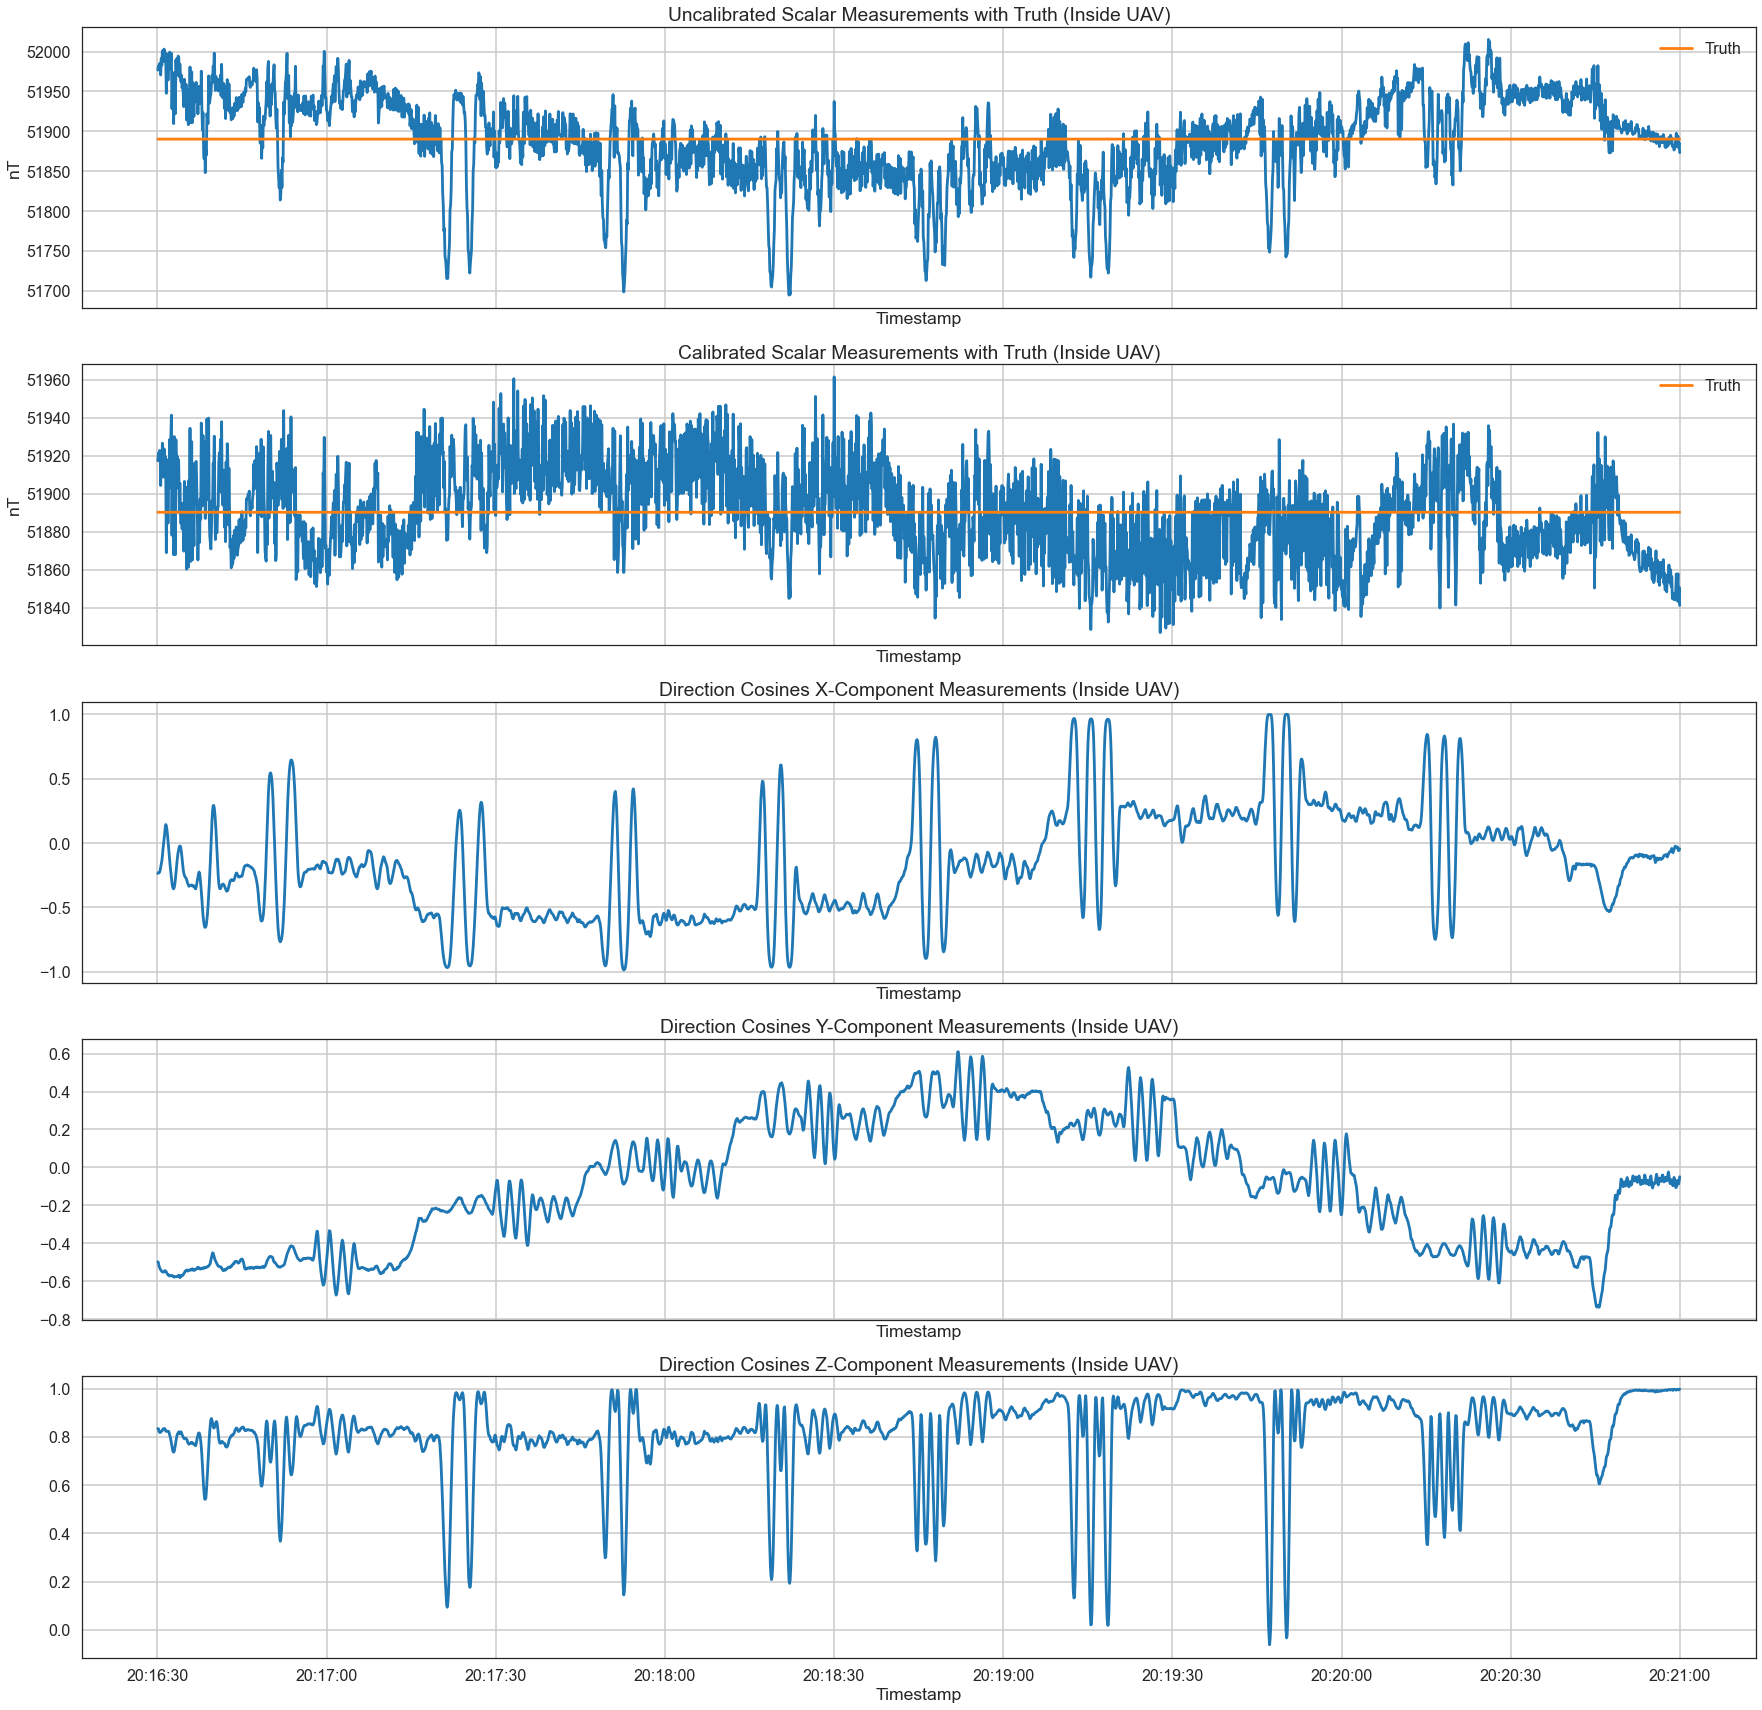

In [13]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply TL Calibration Coefficients (Eddy TL Terms + MFAM Vector Sensor)

In [14]:
tl_terms = [magtl.TollesLawsonTerms.EDDY]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 7.76481406e+05 -1.09619892e+03  8.68036381e+03  1.20339628e+02
  8.24690673e+05 -2.77691813e+03  6.40046539e+03 -6.37947861e+03
  8.03093653e+05]
RMSE: 54.83502706739999


# Post-Calibration Plots (Eddy TL Terms + MFAM Vector Sensor)

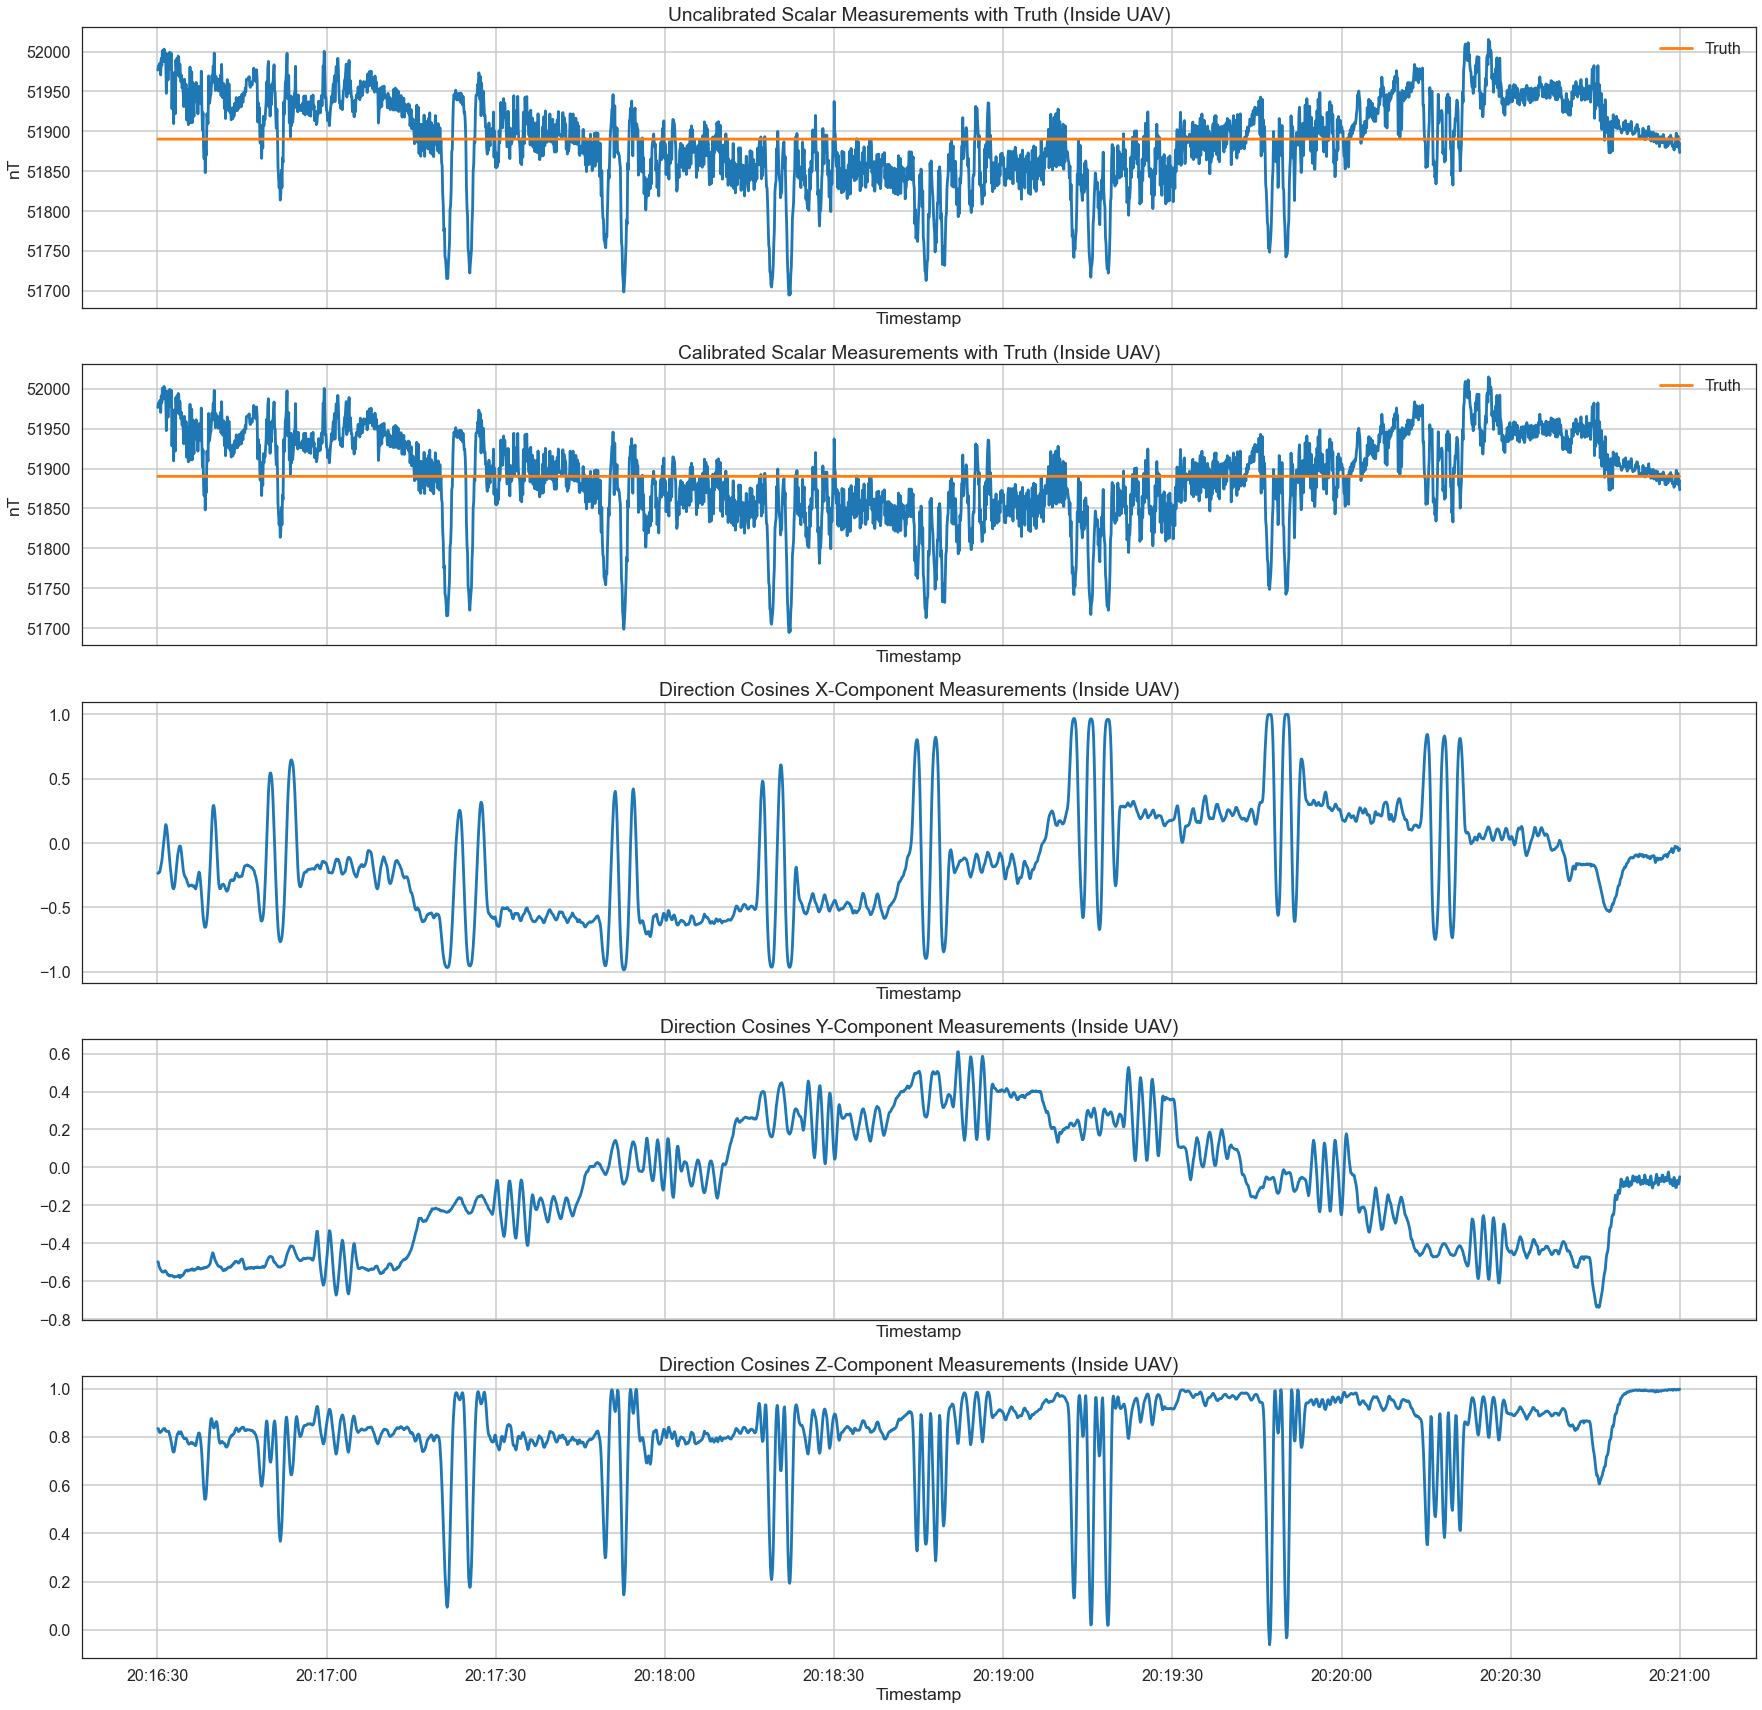

In [15]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              mfam_vec_dcs)

# Find/Apply Tolles Lawson (TL) Calibration Coefficients (All TL Terms + VMR Vector Sensor)

In [16]:
tl_terms = magtl.DEFAULT_TL_TERMS

b_vector = vmr

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [-1.86687725e+01  1.33975396e+02 -1.80762945e+02  1.69023832e-01
 -3.92262356e-03 -1.84382741e-03  1.71830230e-01 -1.61173781e-04
  1.72575427e-01 -4.31927864e-04 -8.21512835e-05 -4.37609432e-05
 -1.06838978e-04 -1.22444017e-04 -2.76294434e-04 -8.51727772e-05
  3.16374022e-05 -2.77441572e-05]
RMSE: 20.421044136995583


# Post-Calibration Plots (All TL Terms + VMR Vector Sensor)

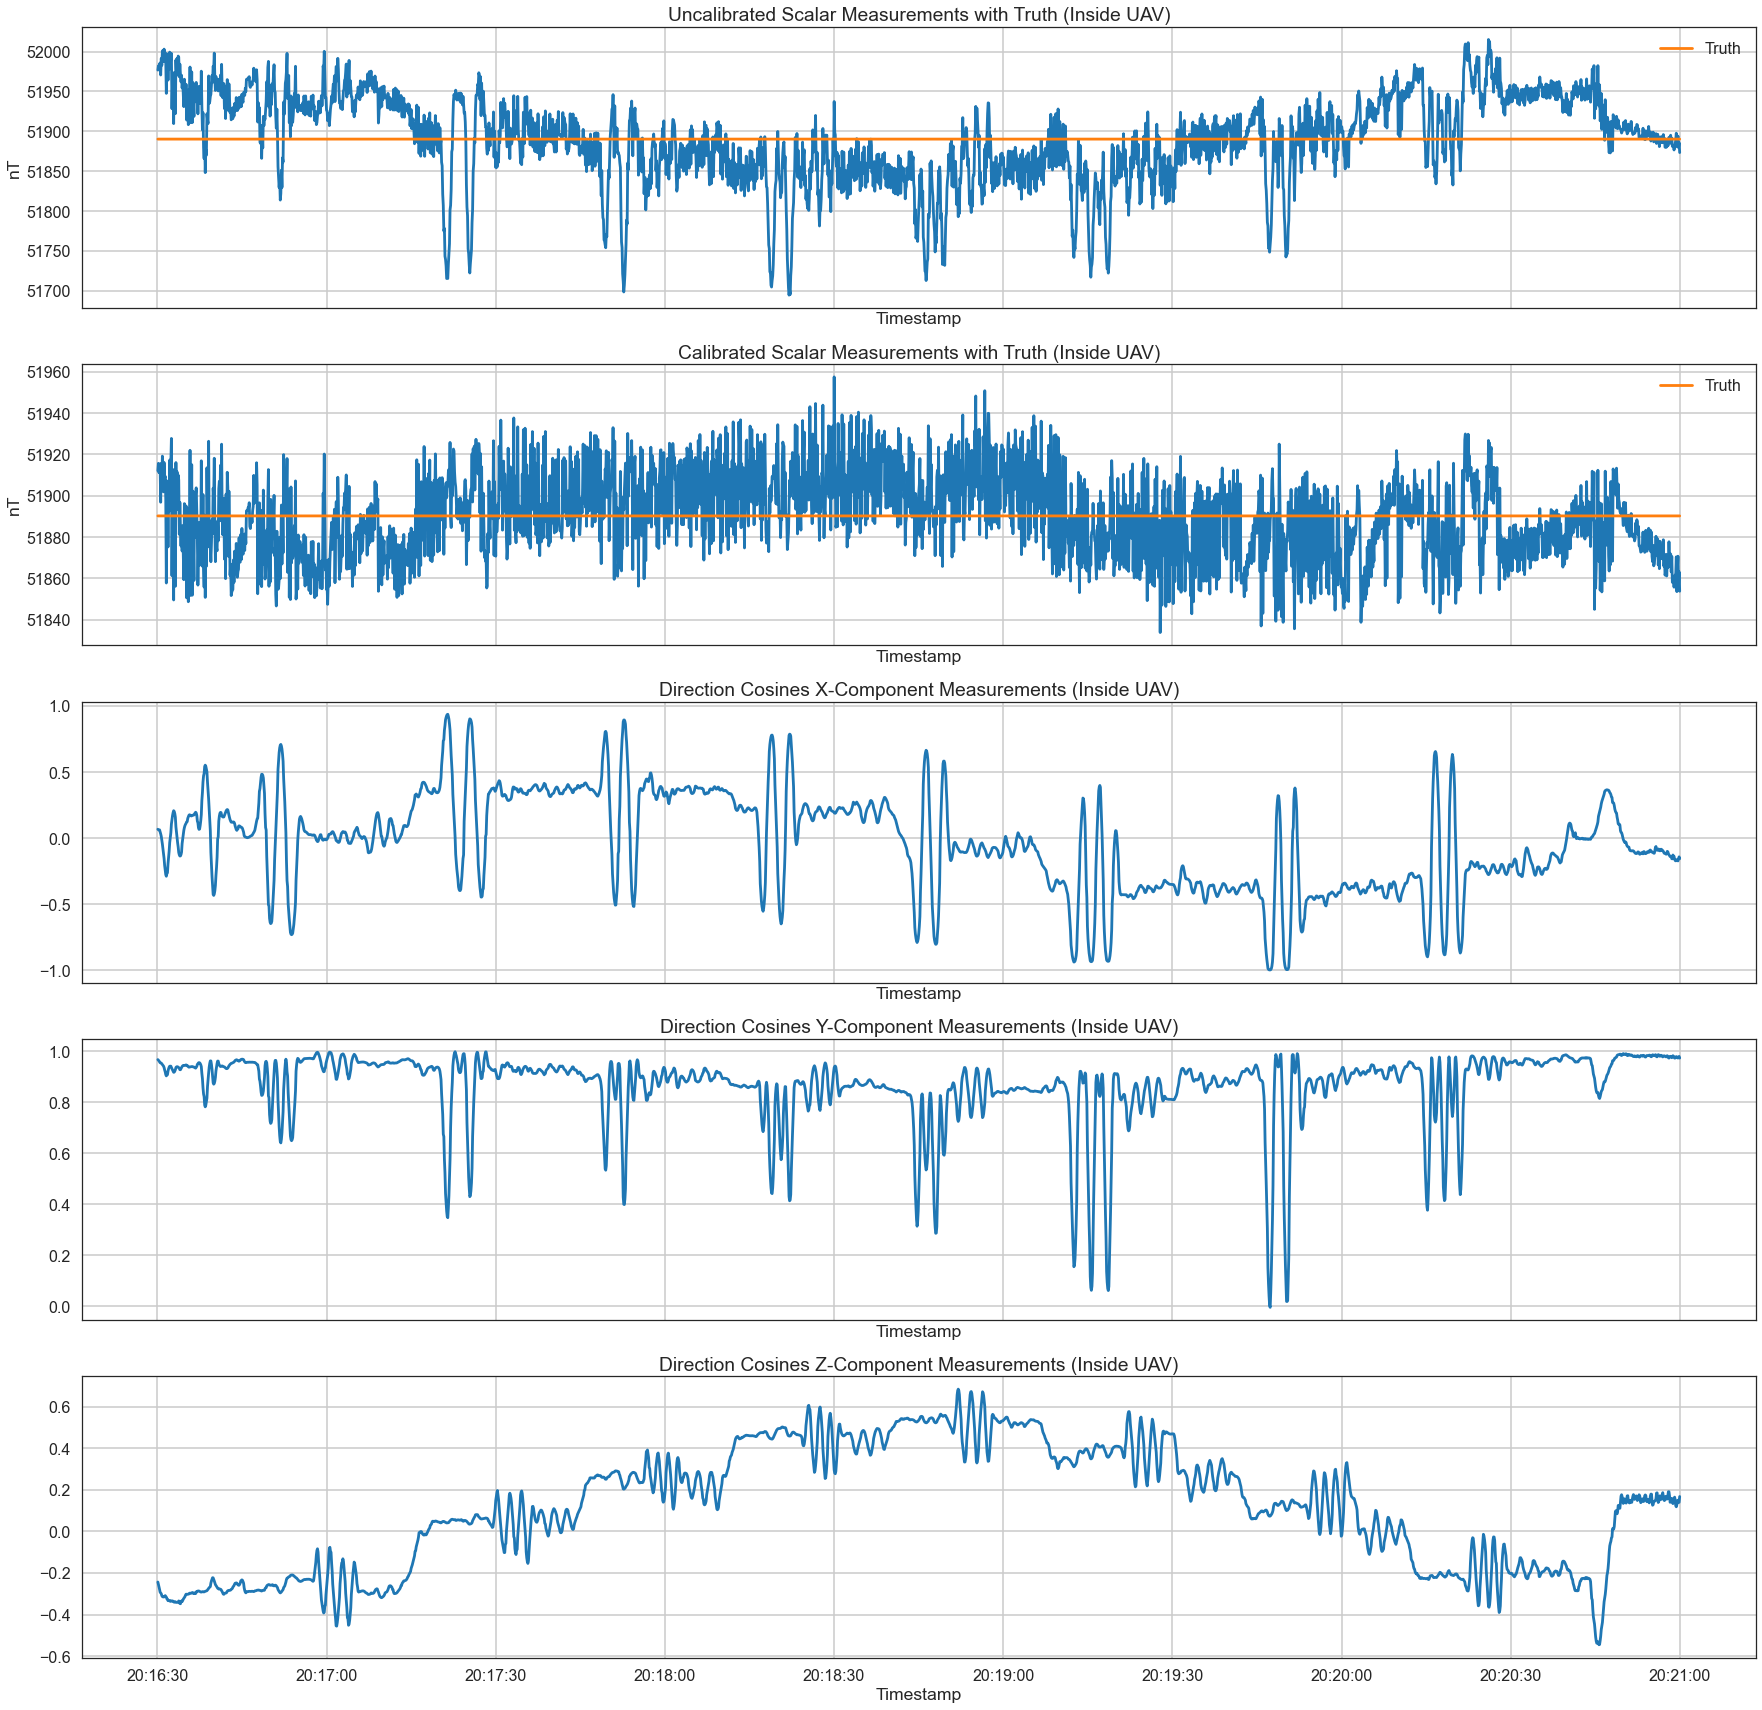

In [17]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)

# Find/Apply TL Calibration Coefficients (Permanent and Induced TL Terms + VMR Vector Sensor)

In [18]:
tl_terms = [magtl.TollesLawsonTerms.PERMANENT,
            magtl.TollesLawsonTerms.INDUCED]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [-1.92711562e+01  1.34573533e+02 -1.79722461e+02  1.69142914e-01
 -3.91198310e-03 -1.83581250e-03  1.71946543e-01 -1.88367158e-04
  1.72701774e-01]
RMSE: 20.504957379980613


# Post-Calibration Plots (Permanent and Induced TL Terms + VMR Vector Sensor)

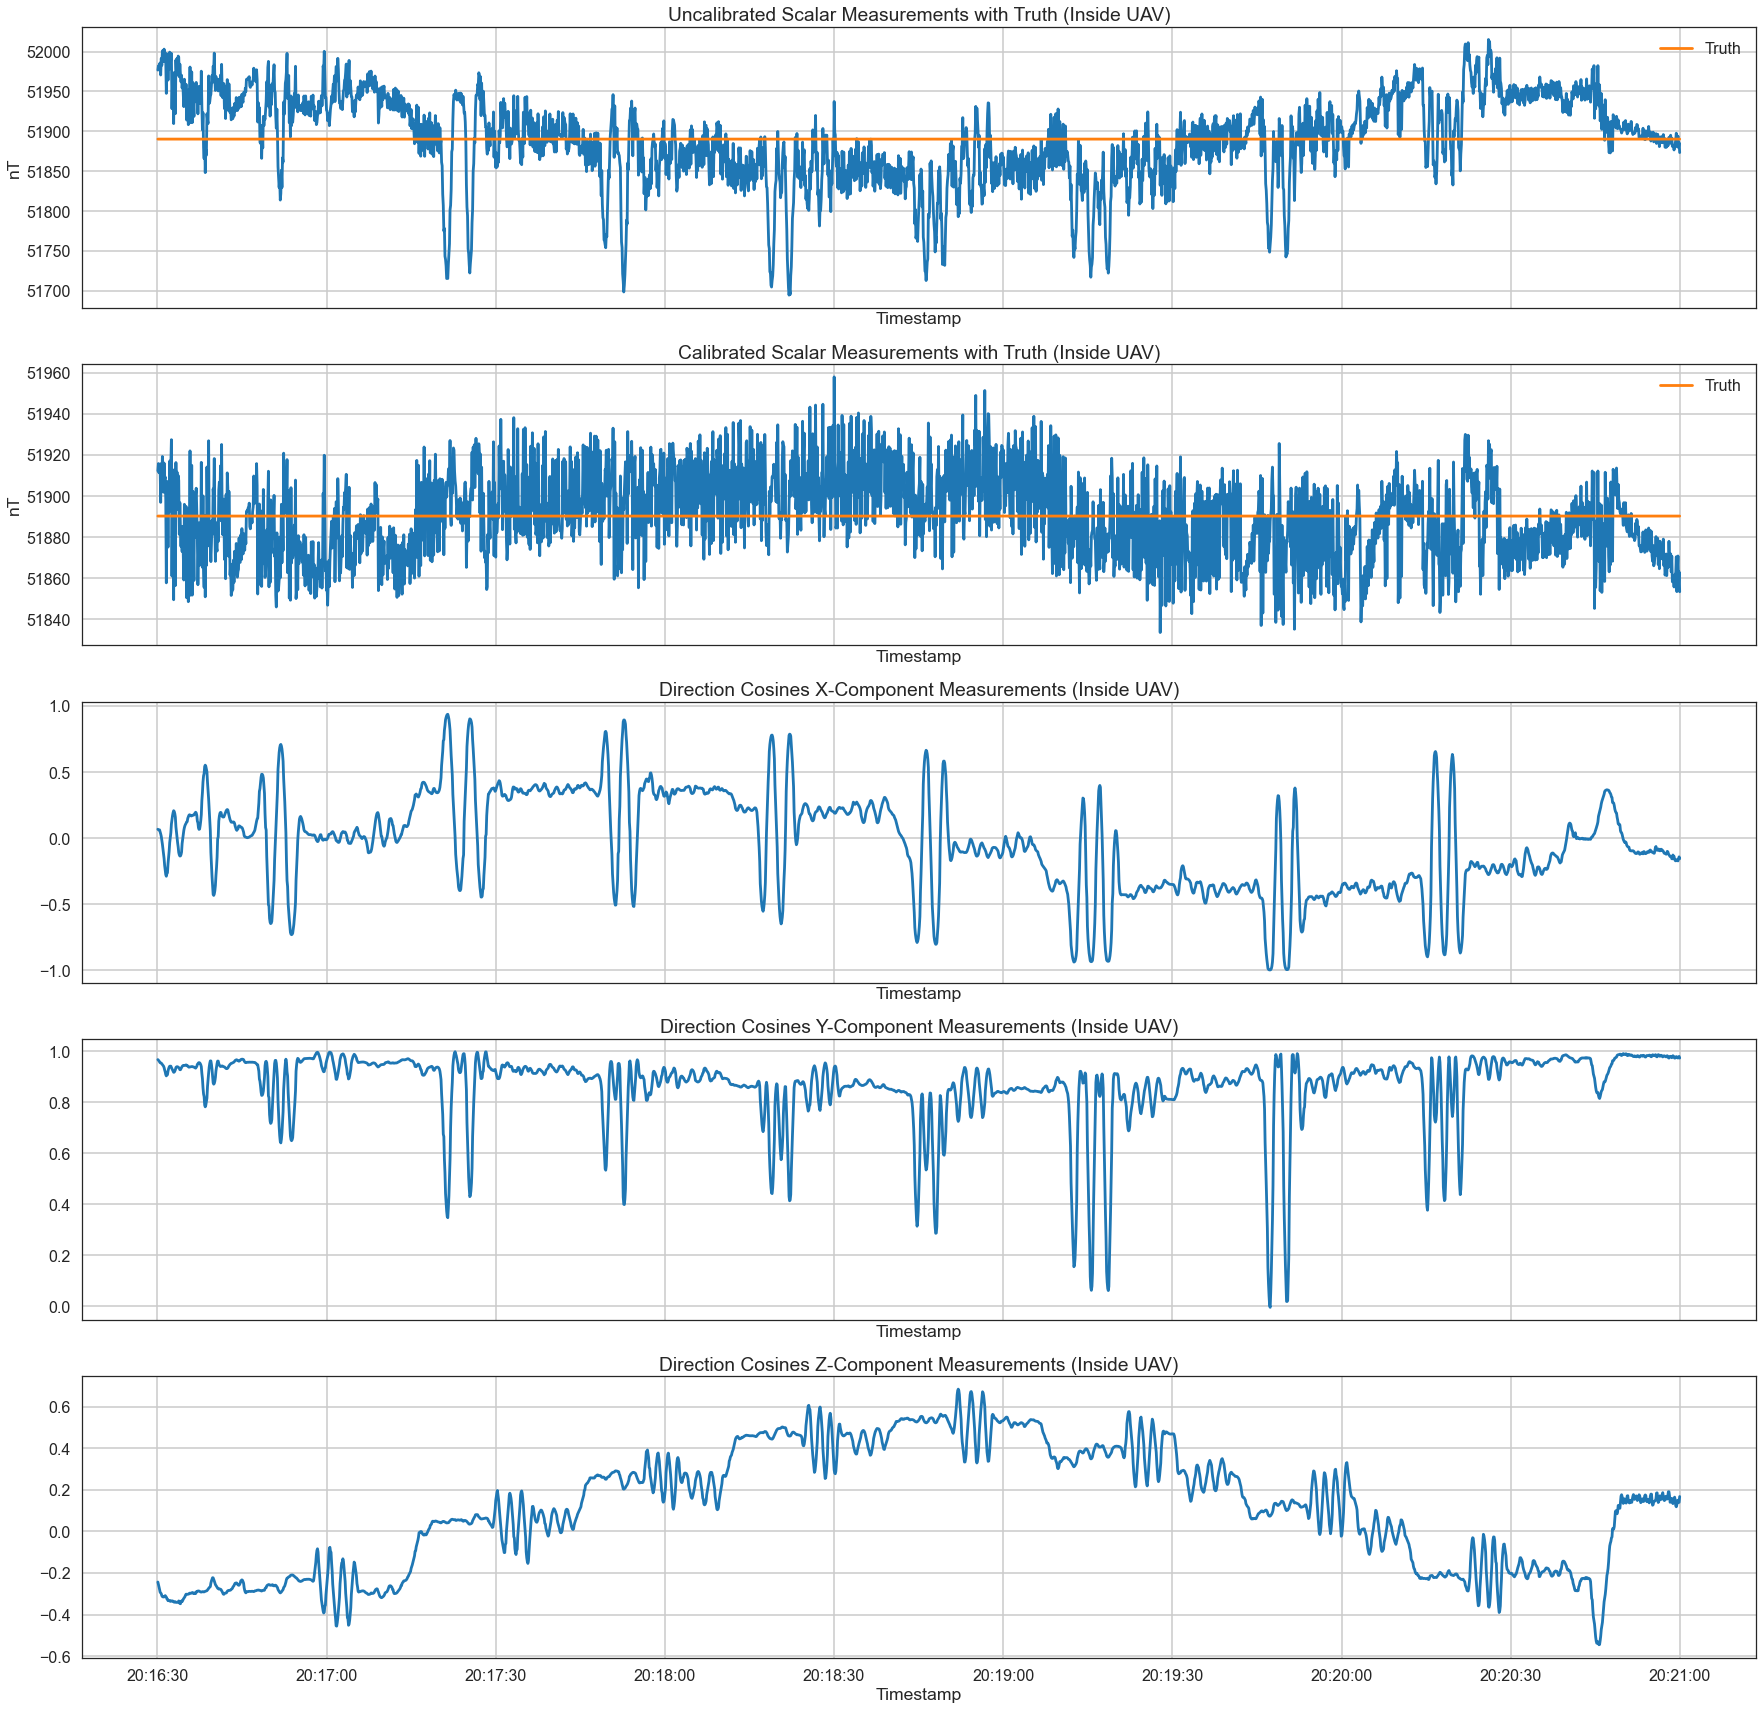

In [19]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)

# Find/Apply TL Calibration Coefficients (Permanent TL Terms + VMR Vector Sensor)

In [20]:
tl_terms = [magtl.TollesLawsonTerms.PERMANENT]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ -72.37506349  239.17181255 -131.38415659]
RMSE: 22.774860653433652


# Post-Calibration Plots (Permanent TL Terms + VMR Vector Sensor)

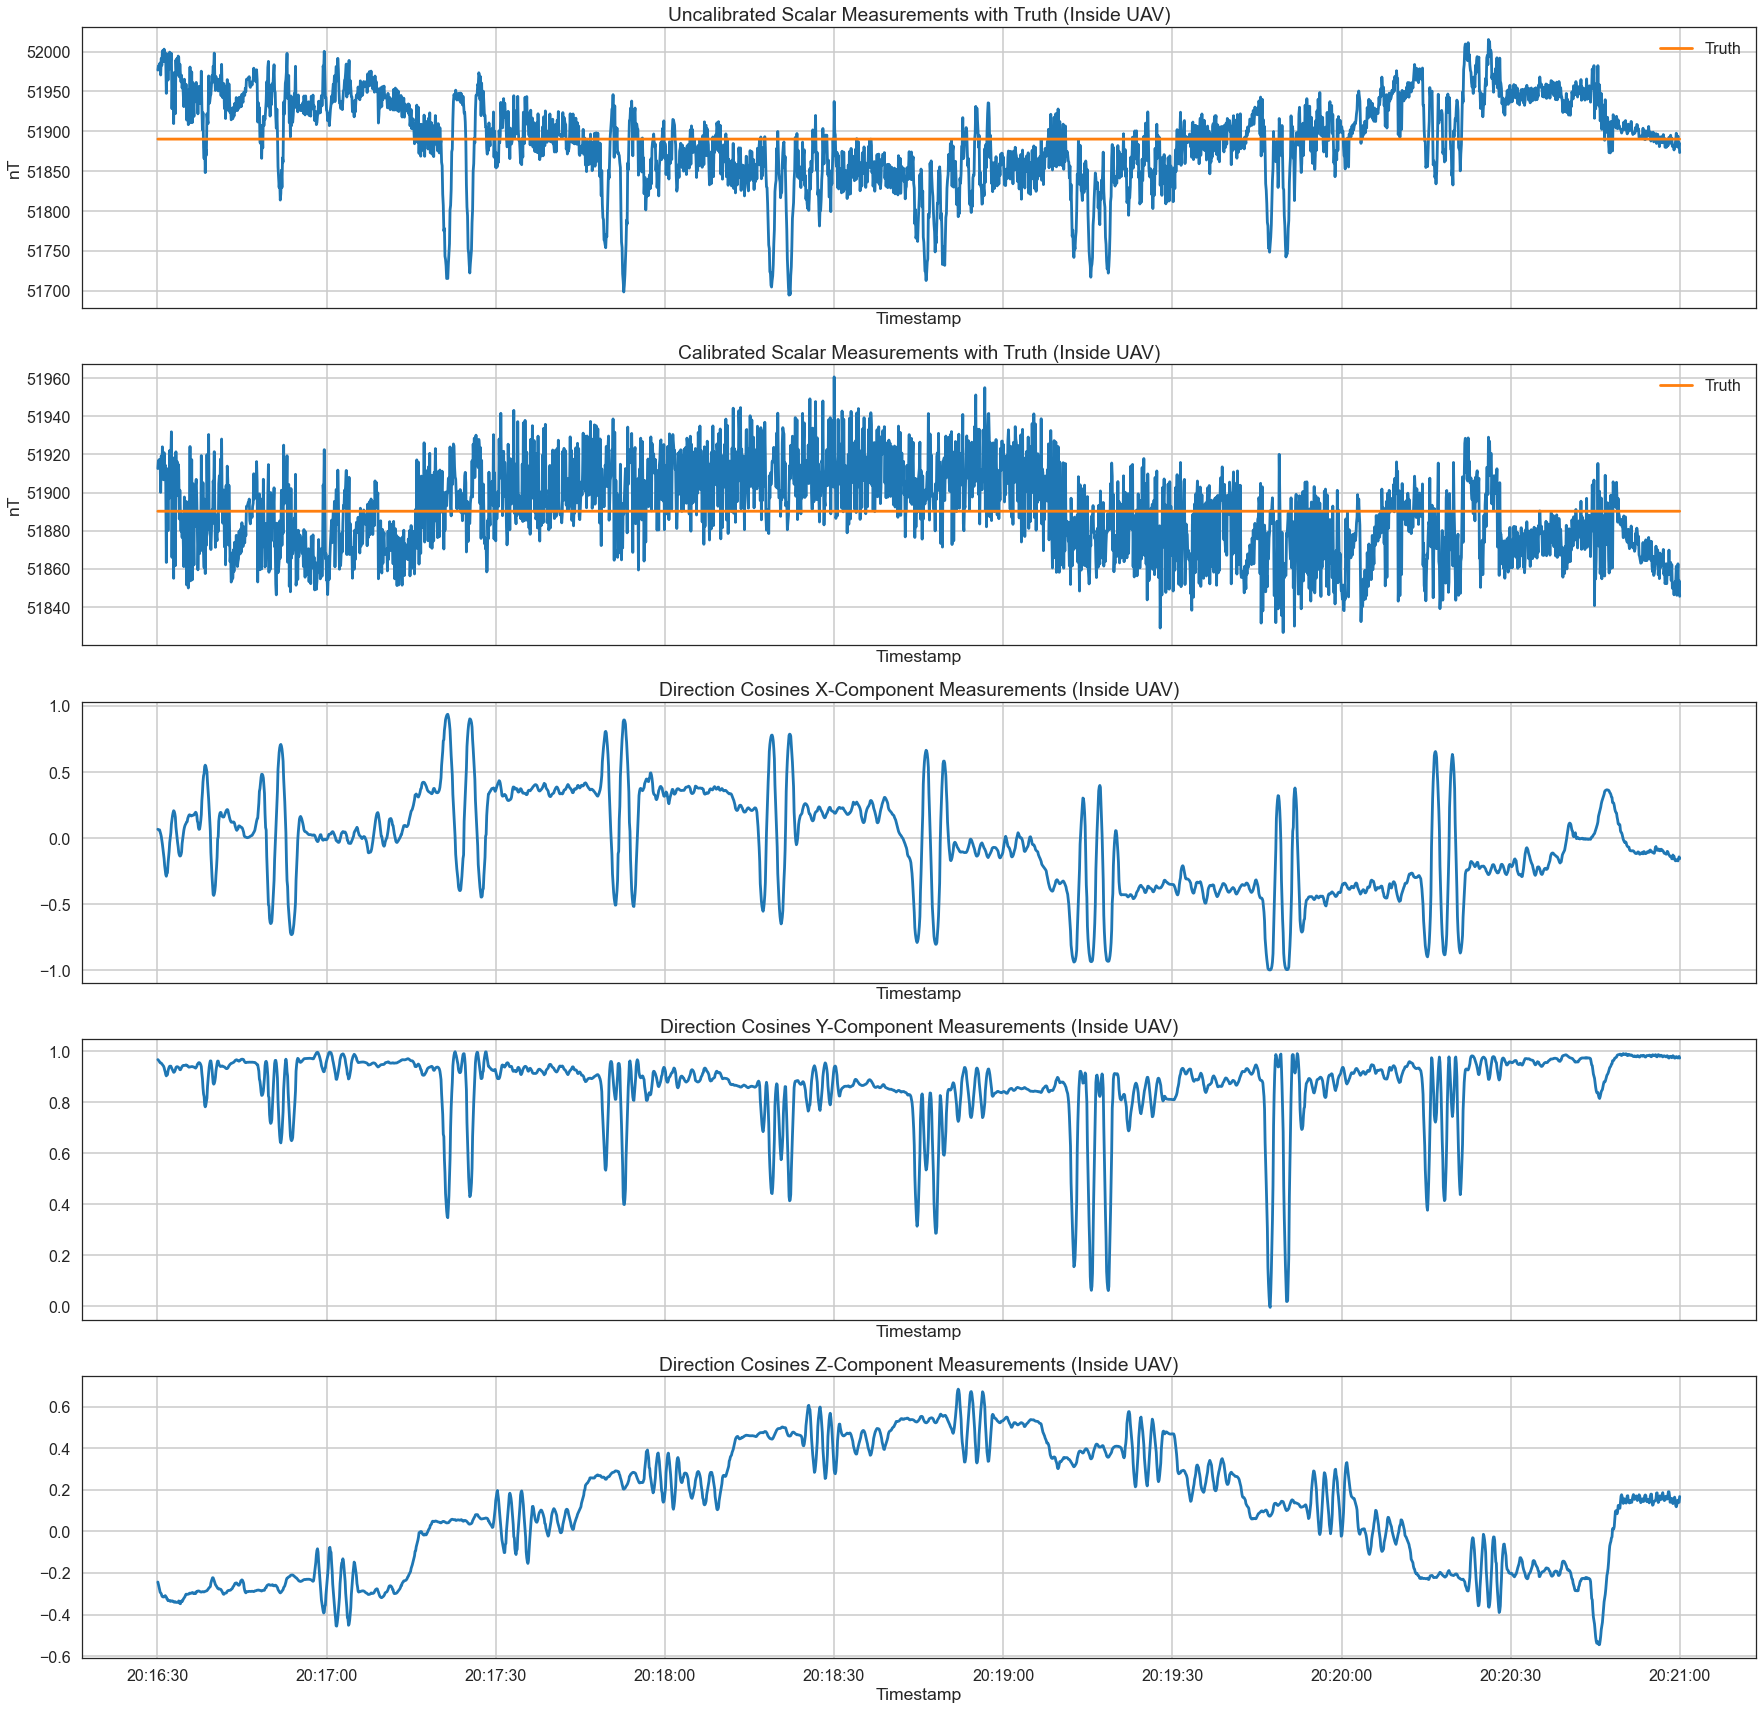

In [21]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)

# Find/Apply TL Calibration Coefficients (Induced TL Terms + VMR Vector Sensor)

In [22]:
tl_terms = [magtl.TollesLawsonTerms.INDUCED]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 0.12050356 -0.00380869 -0.0011042   0.12517448 -0.00311316  0.12333525]
RMSE: 21.822278973507636


# Post-Calibration Plots (Induced TL Terms + VMR Vector Sensor)

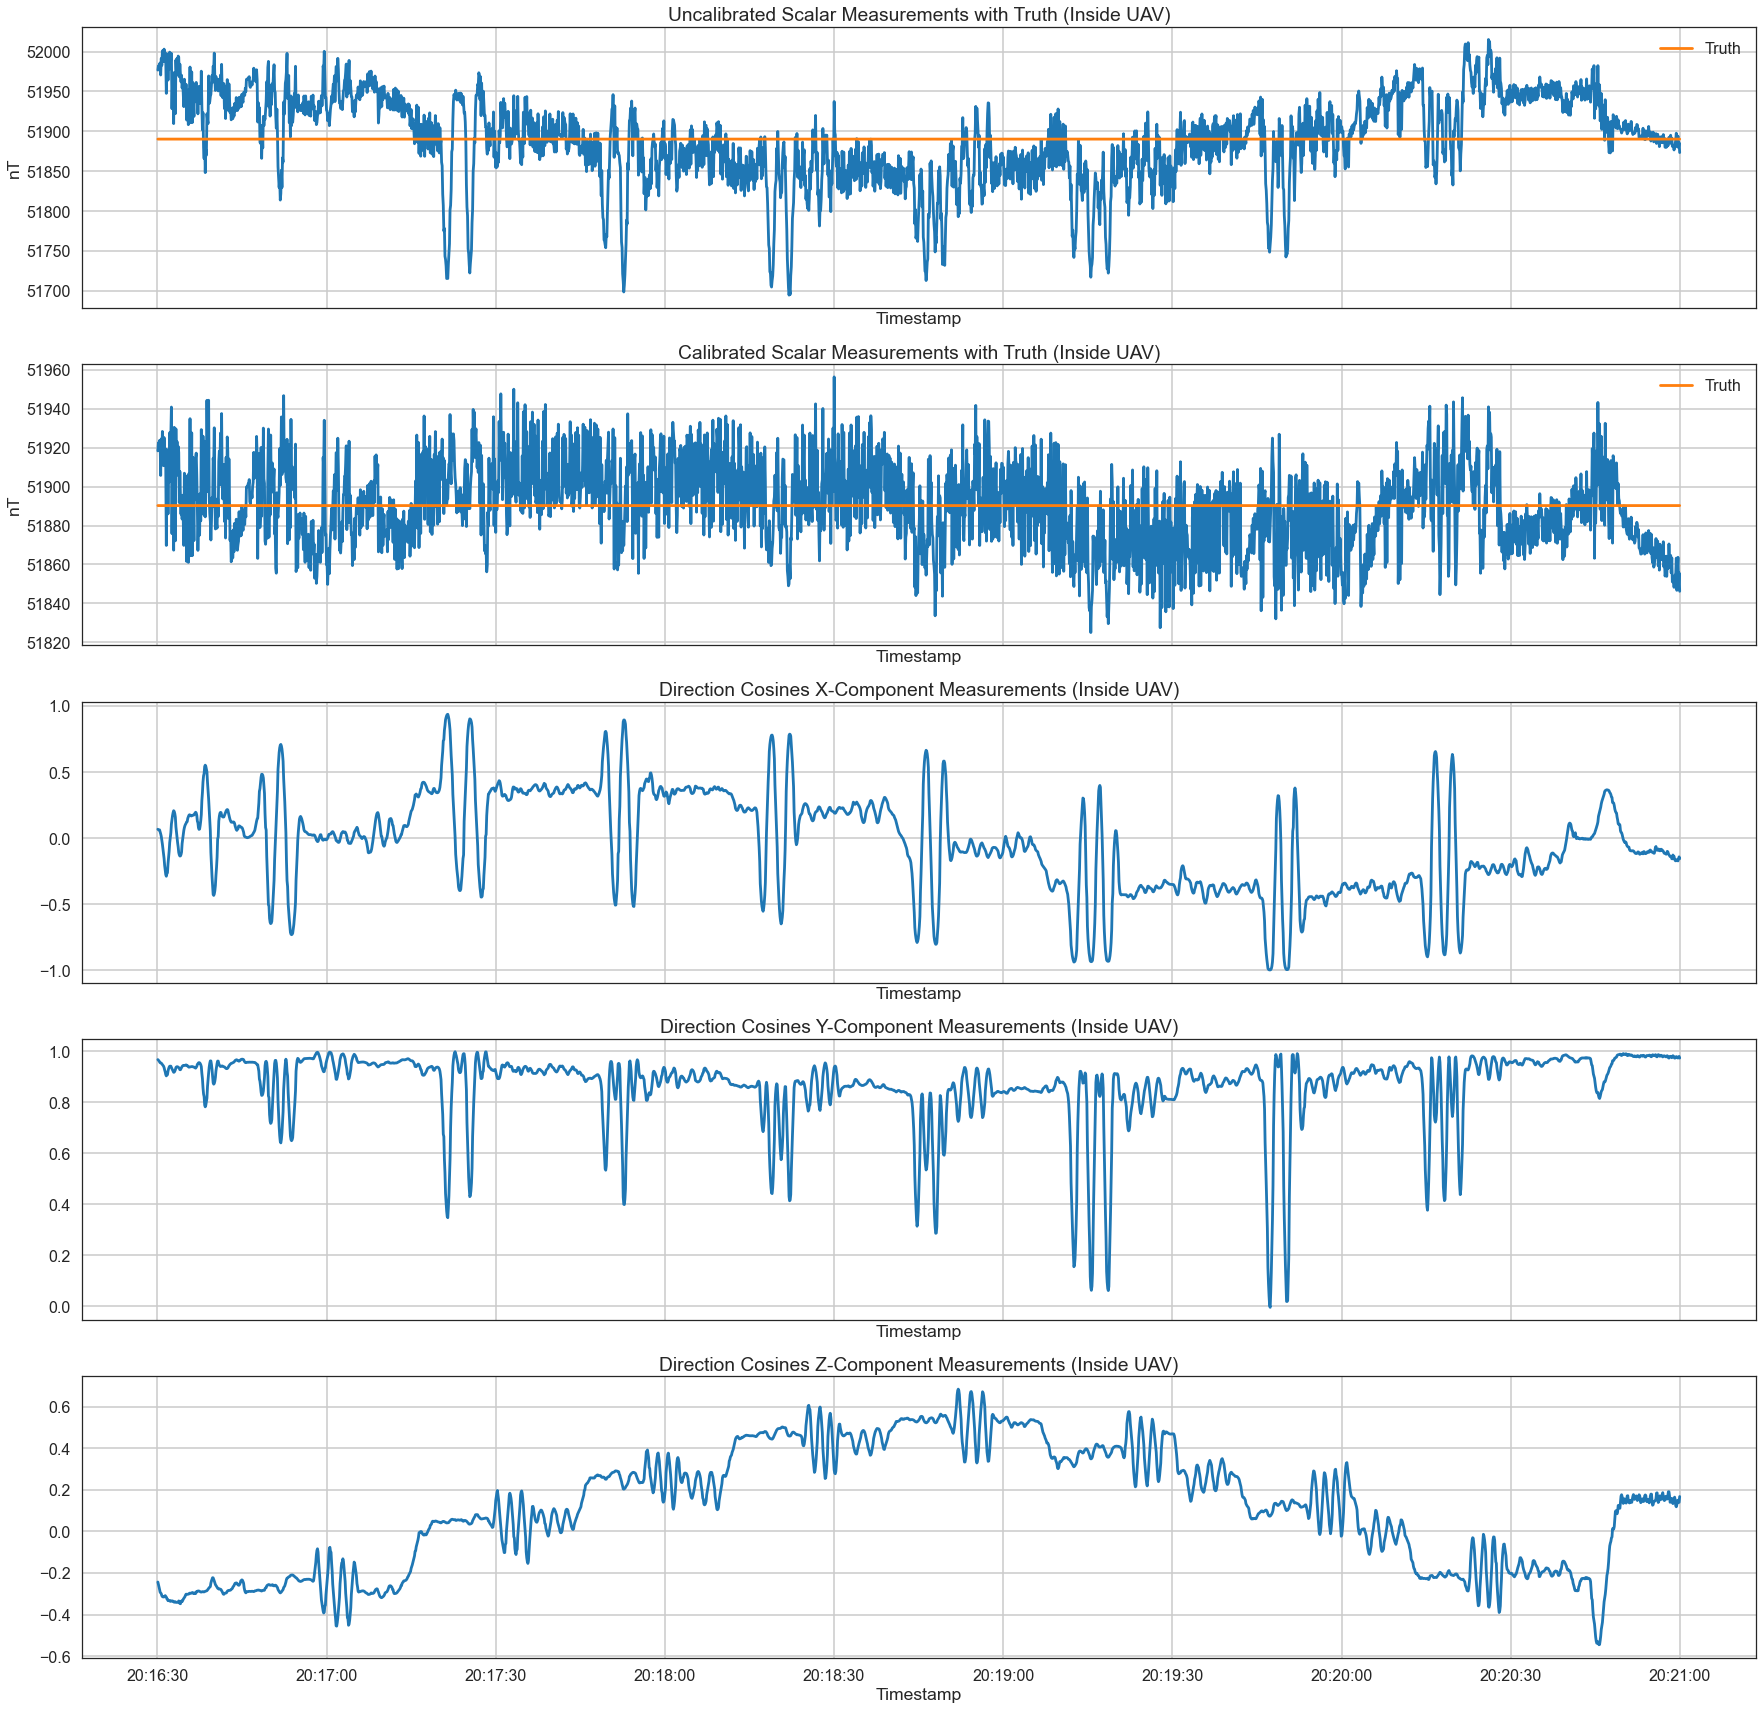

In [23]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)

# Find/Apply TL Calibration Coefficients (Eddy TL Terms + VMR Vector Sensor)

In [24]:
tl_terms = [magtl.TollesLawsonTerms.EDDY]

scalar_terms = magtl.tolles_lawson_coefficients(vector       = b_vector,
                                                y_value      = b_scalar,
                                                time_delta   = delta_t,
                                                apply_filter = True,
                                                mag_filter   = filt,
                                                terms        = tl_terms)

print('TL Terms:', scalar_terms)

body_effects = magtl.tlc_compensation(vector = b_vector,
                                      tlc    = scalar_terms,
                                      terms  = tl_terms)

cal_scalar = b_scalar - body_effects
cal_scalar -= (cal_scalar.mean() - b_scalar.mean()) # Bad fix for issue where TL adds a huge offset

b_scalar_truth = np.ones(b_scalar.shape) * b_scalar.mean()
b_scalar_error = np.abs(cal_scalar - b_scalar_truth)

print('RMSE:', pu.rmse(cal_scalar, b_scalar_truth))

TL Terms: [ 1.77256213e-03 -1.07703822e-04 -1.41034304e-04 -1.24440384e-04
  2.12831789e-03 -2.86511041e-04 -5.66089448e-05  3.04021500e-05
  2.23973567e-03]
RMSE: 54.81114432062239


# Post-Calibration Plots (Eddy TL Terms + VMR Vector Sensor)

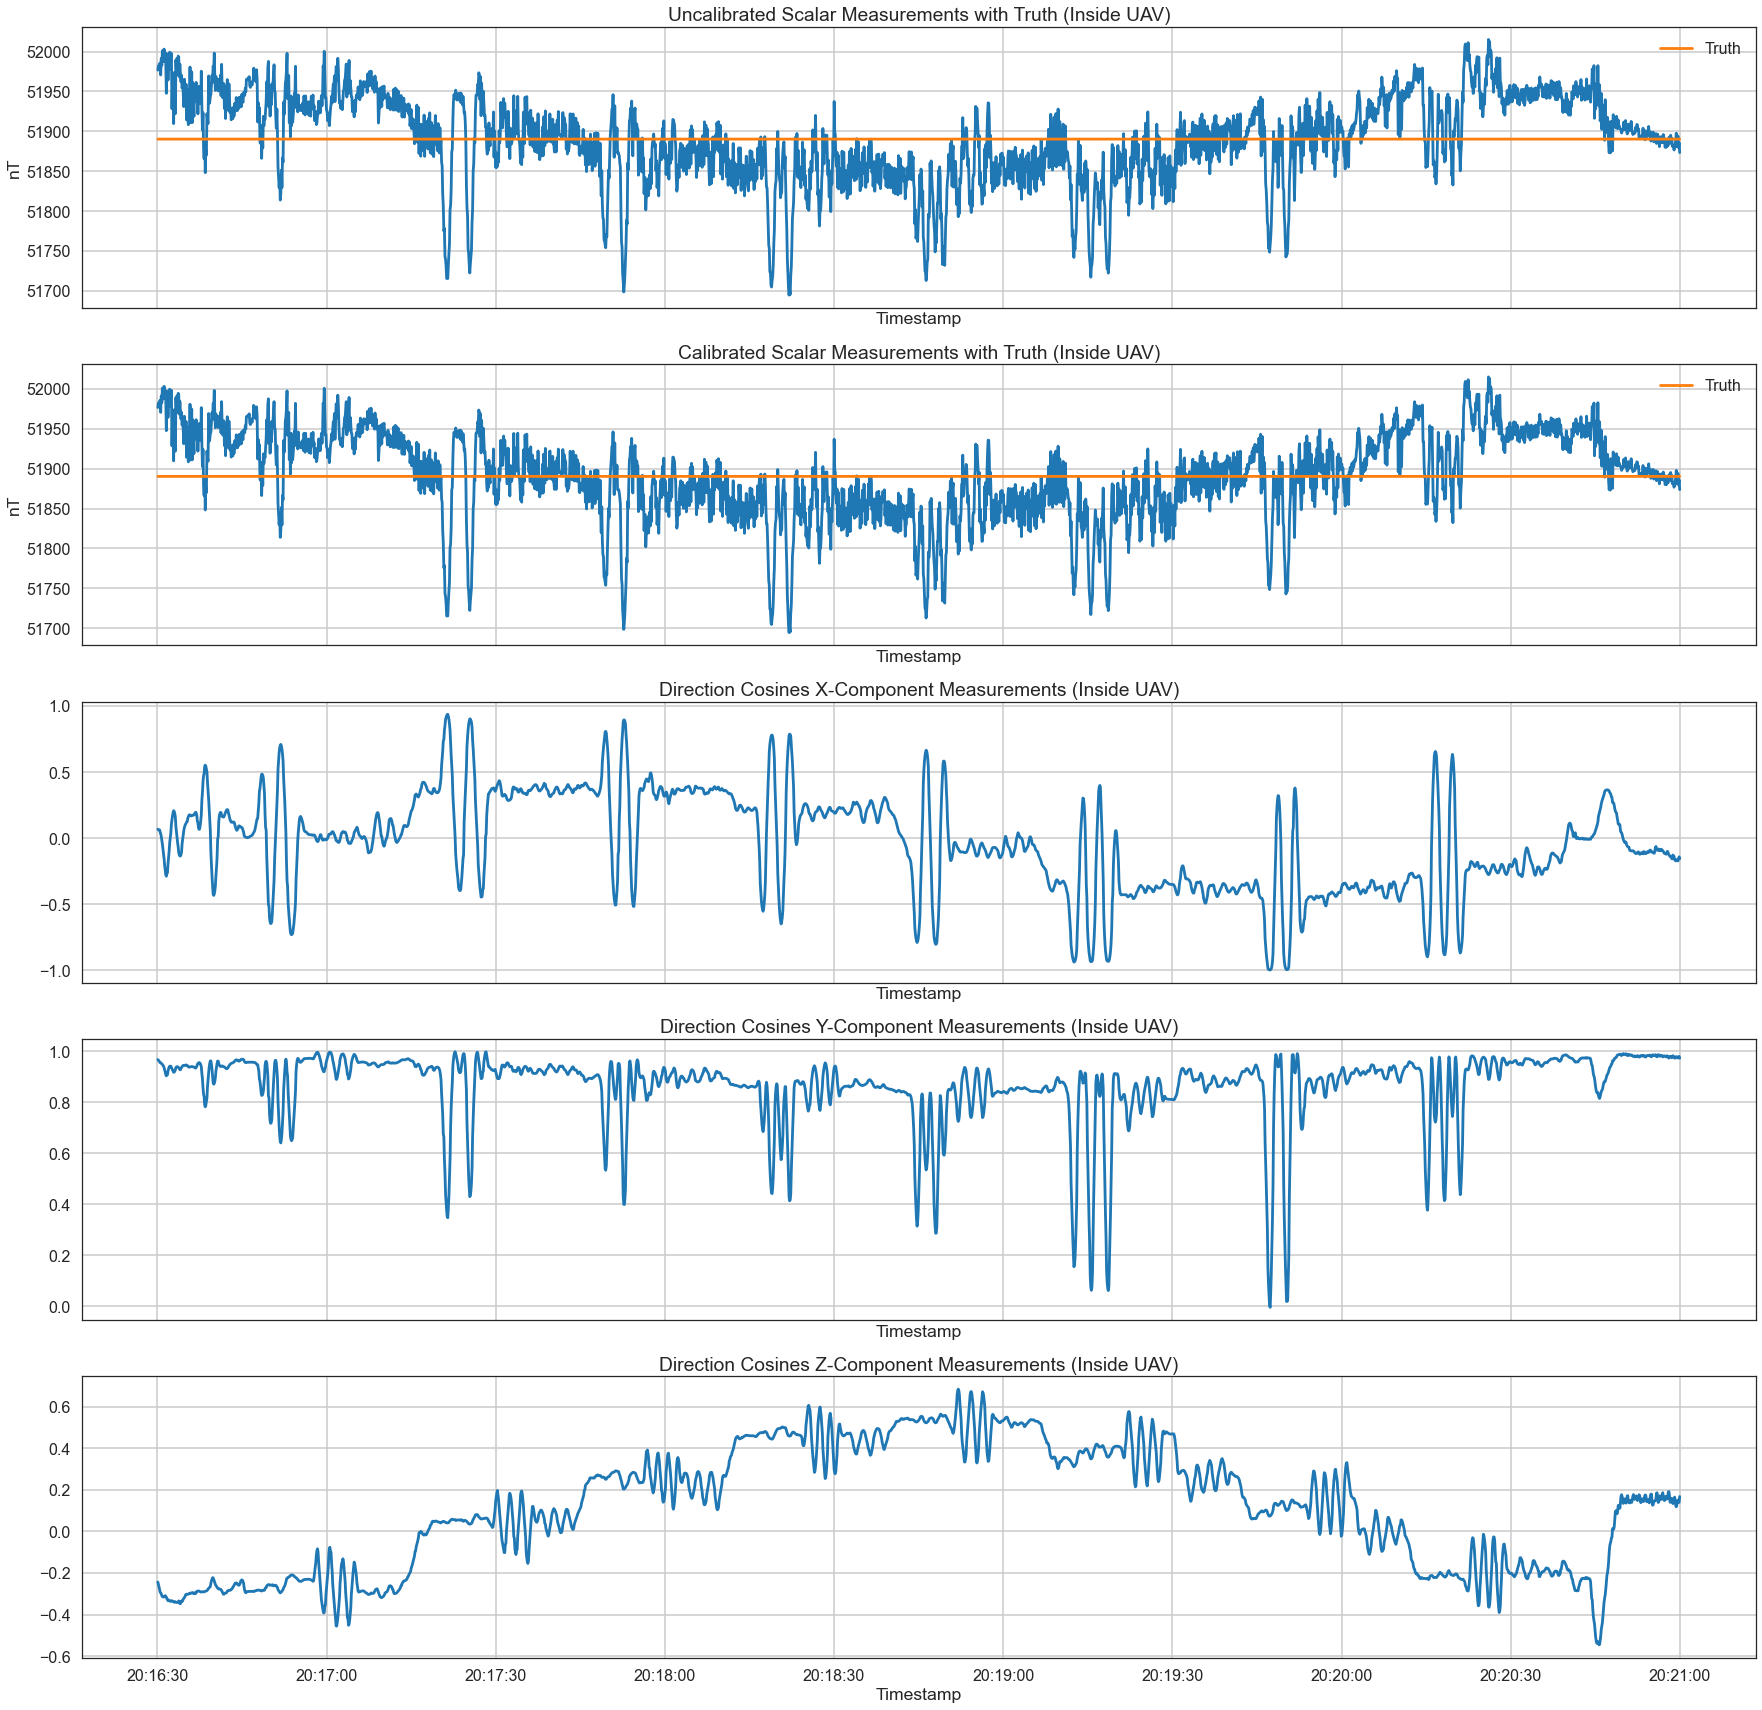

In [25]:
postcal_plots(datetimes,
              b_scalar,
              b_scalar_truth,
              cal_scalar,
              vmr_dcs)